## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

#For visualisation
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#For handling string operation
import string

#For regular expressions
import re

#For text preprocessing
import nltk
import spacy
from nltk import punkt, tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#For sentiment analysis
from textblob import TextBlob

#For visualising text data
from wordcloud import WordCloud, STOPWORDS

#For converting the text data to numerical data
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

#For oversampling
import imblearn
from imblearn.over_sampling import SMOTE

#For selecting the best parameters for the model
from sklearn.model_selection import GridSearchCV

#For model building
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#For model evaluation
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## Import data

In [2]:
hotel_data = pd.read_excel("hotel_reviews.xlsx")
hotel_data.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

## EDA

In [3]:
hotel_data.shape

(20491, 2)

**There are 20491 Ratings and Reviews**

In [4]:
hotel_data.isna().sum()

Review    0
Rating    0
dtype: int64

**There is no null value in the dataset**

In [5]:
hotel_data.duplicated().sum()

0

**There is no duplicate value in the dataset**

In [6]:
hotel_data['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

<AxesSubplot:title={'center':'Rating Distribution'}, xlabel='Rating', ylabel='count'>

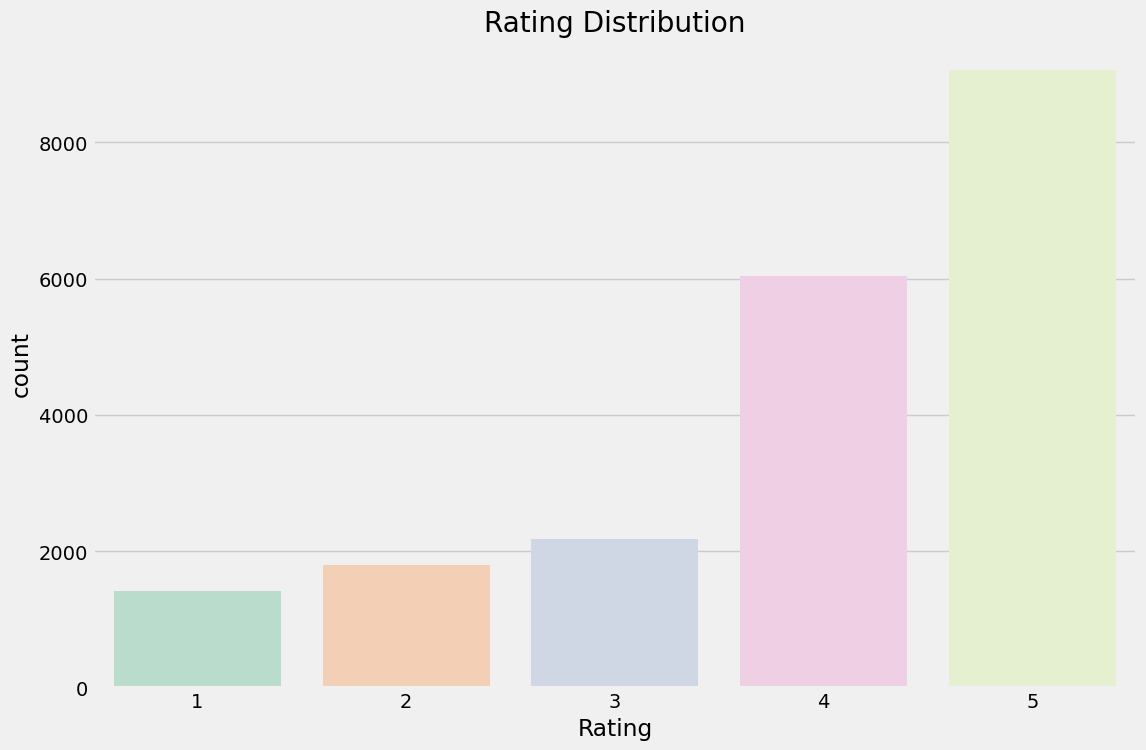

In [7]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
plt.title('Rating Distribution')
sns.countplot(data = hotel_data , x='Rating', palette='Pastel2')

**5 and 4 ratings are significantly more as compared to 1, 2 and 3 ratings. So we can tell that the hotel is performing well**

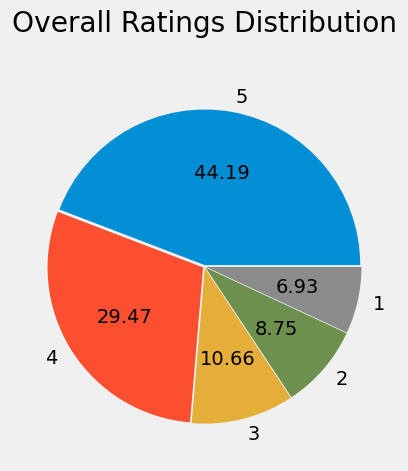

In [8]:
#Checking the total contribution of all ratings
plt.pie(hotel_data['Rating'].value_counts(), autopct='%0.2f', labels=['5', '4', '3', '2', '1'], explode=[0.01, 0.01, 0.01, 0.01, 0.01])
plt.title('Overall Ratings Distribution\n')
plt.show()

**The percentage of 4 and 5 rating is around 73% in the dataset**.

## Text preprocessing

### 1.Removing contractions

In [9]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
hotel_data['no_contraction']=hotel_data['Review'].apply(lambda x:expand_contractions(x))

In [10]:
hotel_data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      no_contraction  
0  nice hotel expensive parking got good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice rooms not 4* experience hotel monaco seat...  
3  unique, great stay, wonderful time hotel monac...  
4  great stay great stay, went seahawk game aweso...

**If there are any english contractions in the data, they are expanded**

### 2.Removing digits

In [11]:
hotel_data['no_digits']=hotel_data['no_contraction'].apply(lambda x: re.sub('\w*\d\w*','', x))
hotel_data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      no_contraction  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           no_digits  
0  nice hotel expensive parking got good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice rooms not * experience hotel monaco seatt...  
3  unique, great stay, wonderful time hotel monac...  
4  great stay great stay, went seahawk game aweso...

**Here the digits are removed**

### 3.Removing the Punctuation

In [12]:
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
hotel_data['No_punctuation']= hotel_data['no_digits'].apply(lambda x:remove_punctuation(x))
hotel_data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      no_contraction  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           no_digits  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not * experience hotel monaco seatt...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                      No_punctuation  
0  nice hotel expensive parking got good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice rooms not  experience hotel monaco seattl...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay went seahawk game awesom...

**Some of the charaters in the text are removed here**

### 4.lowering the text(Normalising)

In [13]:
hotel_data['lowered_text'] = hotel_data['No_punctuation'].apply(lambda x:x.lower())
hotel_data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      no_contraction  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           no_digits  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not * experience hotel monaco seatt...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                      No_punctuation  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                        lowered_text  
0  nice hotel expensive parking got good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice rooms not  experience hotel monaco seattl...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay went seahawk game awesom...

**All the text are lowered**

### 5.tokenization

In [14]:
hotel_data['tokenized']= hotel_data['lowered_text'].apply(lambda x:word_tokenize(x))
hotel_data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      no_contraction  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           no_digits  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not * experience hotel monaco seatt...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                      No_punctuation  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                        lowered_text  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                           tokenized  
0  [nice, hotel, expensive, parking, got, good, d...  
1  [ok, nothing, special, charge, diamond, member...  
2  [nice, rooms, not, experience, hotel, monaco, ...  
3  [unique, great, stay, wonderful, time, hotel, ...  
4  [great, stay, great, stay, went, seahawk, game...

**The sentences are split into small words using the tokenize function**

### 6.Removing the stopwords

In [22]:
my_stop_words = stopwords.words('english')
my_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [23]:
newStopwords = ['the','hotel','room','resort','restaurant']
my_stop_words.extend(newStopwords)

In [25]:
my_stop_words.remove('not')

In [26]:
my_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [27]:
def remove_stopwords(text):
    output= [i for i in text if i not in my_stop_words]
    return output

In [28]:
#applying the function
hotel_data['no_stopwords']= hotel_data['tokenized'].apply(lambda x:remove_stopwords(x))
hotel_data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      no_contraction  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           no_digits  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not * experience hotel monaco seatt...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                      No_punctuation  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                        lowered_text  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                           tokenized  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, experience, hotel, monaco, ...   
3  [unique, great, stay, wonderful, time, hotel, ...   
4  [great, stay, great, stay, went, seahawk, game...   

                                        no_stopwords  
0  [nice, expensive, parking, got, good, deal, st...  
1  [ok, nothing, special, charge, diamond, member...  
2  [nice, rooms, not, experience, monaco, seattle...  
3  [unique, great, stay, wonderful, time, monaco,...  
4  [great, stay, great, stay, went, seahawk, game...

**Stopwords are the English words which does not add much meaning to a sentence.We remove these words using the above function**

### 7.Stemming

In [29]:
#defining the object for stemming
porter_stemmer = PorterStemmer()

#defining a function for stemming
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

In [30]:
hotel_data['stemmed']=hotel_data['no_stopwords'].apply(lambda x: stemming(x))
hotel_data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      no_contraction  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           no_digits  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not * experience hotel monaco seatt...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                      No_punctuation  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                        lowered_text  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                           tokenized  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, experience, hotel, monaco, ...   
3  [unique, great, stay, wonderful, time, hotel, ...   
4  [great, stay, great, stay, went, seahawk, game...   

                                        no_stopwords  \
0  [nice, expensive, parking, got, good, deal, st...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, experience, monaco, seattle...   
3  [unique, great, stay, wonderful, time, monaco,...   
4  [great, stay, great, stay, went, seahawk, game...   

                                             stemmed  
0  [nice, expens, park, got, good, deal, stay, an...  
1  [ok, noth, special, charg, diamond, member, hi...  
2  [nice, room, not, experi, monaco, seattl, good...  
3  [uniqu, great, stay, wonder, time, monaco, loc...  
4  [great, stay, great, stay, went, seahawk, game...

**Stemming is the process of chopping the words into root/base words**

### 8.Lemmatization

In [31]:
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

In [32]:
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

hotel_data['lemmatized']=hotel_data['no_stopwords'].apply(lambda x:lemmatizer(x))

In [33]:
hotel_data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                      no_contraction  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           no_digits  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not * experience hotel monaco seatt...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                      No_punctuation  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                        lowered_text  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not  experience hotel monaco seattl...   
3  unique great stay wonderful time hotel monaco ...   
4  great stay great stay went seahawk game awesom...   

                                           tokenized  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, experience, hotel, monaco, ...   
3  [unique, great, stay, wonderful, time, hotel, ...   
4  [great, stay, great, stay, went, seahawk, game...   

                                        no_stopwords  \
0  [nice, expensive, parking, got, good, deal, st...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, experience, monaco, seattle...   
3  [unique, great, stay, wonderful, time, monaco,...   
4  [great, stay, great, stay, went, seahawk, game...   

                                             stemmed  \
0  [nice, expens, park, got, good, deal, stay, an...   
1  [ok, noth, special, charg, diamond, member, hi...   
2  [nice, room, not, experi, monaco, seattl, good...   
3  [uniqu, great, stay, wonder, time, monaco, loc...   
4  [great, stay, great, stay, went, seahawk, game...   

                                          lemmatized  
0  [nice, expensive, parking, got, good, deal, st...  
1  [ok, nothing, special, charge, diamond, member...  
2  [nice, room, not, experience, monaco, seattle,...  
3  [unique, great, stay, wonderful, time, monaco,...  
4  [great, stay, great, stay, went, seahawk, game...

**Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word.**

## Sentiment Analysis

In [34]:
hotel_data = hotel_data[['Rating','lemmatized']]
hotel_data.head()

Rating                                         lemmatized
0       4  [nice, expensive, parking, got, good, deal, st...
1       2  [ok, nothing, special, charge, diamond, member...
2       3  [nice, room, not, experience, monaco, seattle,...
3       5  [unique, great, stay, wonderful, time, monaco,...
4       5  [great, stay, great, stay, went, seahawk, game...

In [35]:
hotel_data['lemma_str'] = [' '.join(map(str,l)) for l in hotel_data['lemmatized']]
hotel_data.head()

Rating                                         lemmatized  \
0       4  [nice, expensive, parking, got, good, deal, st...   
1       2  [ok, nothing, special, charge, diamond, member...   
2       3  [nice, room, not, experience, monaco, seattle,...   
3       5  [unique, great, stay, wonderful, time, monaco,...   
4       5  [great, stay, great, stay, went, seahawk, game...   

                                           lemma_str  
0  nice expensive parking got good deal stay anni...  
1  ok nothing special charge diamond member hilto...  
2  nice room not experience monaco seattle good n...  
3  unique great stay wonderful time monaco locati...  
4  great stay great stay went seahawk game awesom...

In [36]:
hotel_data['polarity'] = hotel_data['lemma_str'].apply(lambda x:TextBlob(x).sentiment.polarity)
hotel_data.head()

Rating                                         lemmatized  \
0       4  [nice, expensive, parking, got, good, deal, st...   
1       2  [ok, nothing, special, charge, diamond, member...   
2       3  [nice, room, not, experience, monaco, seattle,...   
3       5  [unique, great, stay, wonderful, time, monaco,...   
4       5  [great, stay, great, stay, went, seahawk, game...   

                                           lemma_str  polarity  
0  nice expensive parking got good deal stay anni...  0.208744  
1  ok nothing special charge diamond member hilto...  0.227204  
2  nice room not experience monaco seattle good n...  0.294420  
3  unique great stay wonderful time monaco locati...  0.504825  
4  great stay great stay went seahawk game awesom...  0.389286

In [37]:
hotel_data['subjectivity'] = hotel_data['lemma_str'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
hotel_data.head()

Rating                                         lemmatized  \
0       4  [nice, expensive, parking, got, good, deal, st...   
1       2  [ok, nothing, special, charge, diamond, member...   
2       3  [nice, room, not, experience, monaco, seattle,...   
3       5  [unique, great, stay, wonderful, time, monaco,...   
4       5  [great, stay, great, stay, went, seahawk, game...   

                                           lemma_str  polarity  subjectivity  
0  nice expensive parking got good deal stay anni...  0.208744      0.687000  
1  ok nothing special charge diamond member hilto...  0.227204      0.523295  
2  nice room not experience monaco seattle good n...  0.294420      0.605208  
3  unique great stay wonderful time monaco locati...  0.504825      0.691228  
4  great stay great stay went seahawk game awesom...  0.389286      0.627296

In [38]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [39]:
hotel_data['sentiment'] = hotel_data['polarity'].apply(getAnalysis)
hotel_data.head()

Rating                                         lemmatized  \
0       4  [nice, expensive, parking, got, good, deal, st...   
1       2  [ok, nothing, special, charge, diamond, member...   
2       3  [nice, room, not, experience, monaco, seattle,...   
3       5  [unique, great, stay, wonderful, time, monaco,...   
4       5  [great, stay, great, stay, went, seahawk, game...   

                                           lemma_str  polarity  subjectivity  \
0  nice expensive parking got good deal stay anni...  0.208744      0.687000   
1  ok nothing special charge diamond member hilto...  0.227204      0.523295   
2  nice room not experience monaco seattle good n...  0.294420      0.605208   
3  unique great stay wonderful time monaco locati...  0.504825      0.691228   
4  great stay great stay went seahawk game awesom...  0.389286      0.627296   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

**Polarity determines the sentiment of the text. Its values lie in [-1,1] where -1 denotes a highly negative sentiment and 1 denotes a highly positive sentiment.**

**Subjectivity determines whether a text input is factual information or a personal opinion. Its value lies between [0,1] where a value closer to 0 denotes a piece of factual information and a value closer to 1 denotes a personal opinion.**

In [40]:
hotel_data.groupby(by='sentiment')['Rating'].count()

sentiment
Negative     1322
Neutral        25
Positive    19144
Name: Rating, dtype: int64

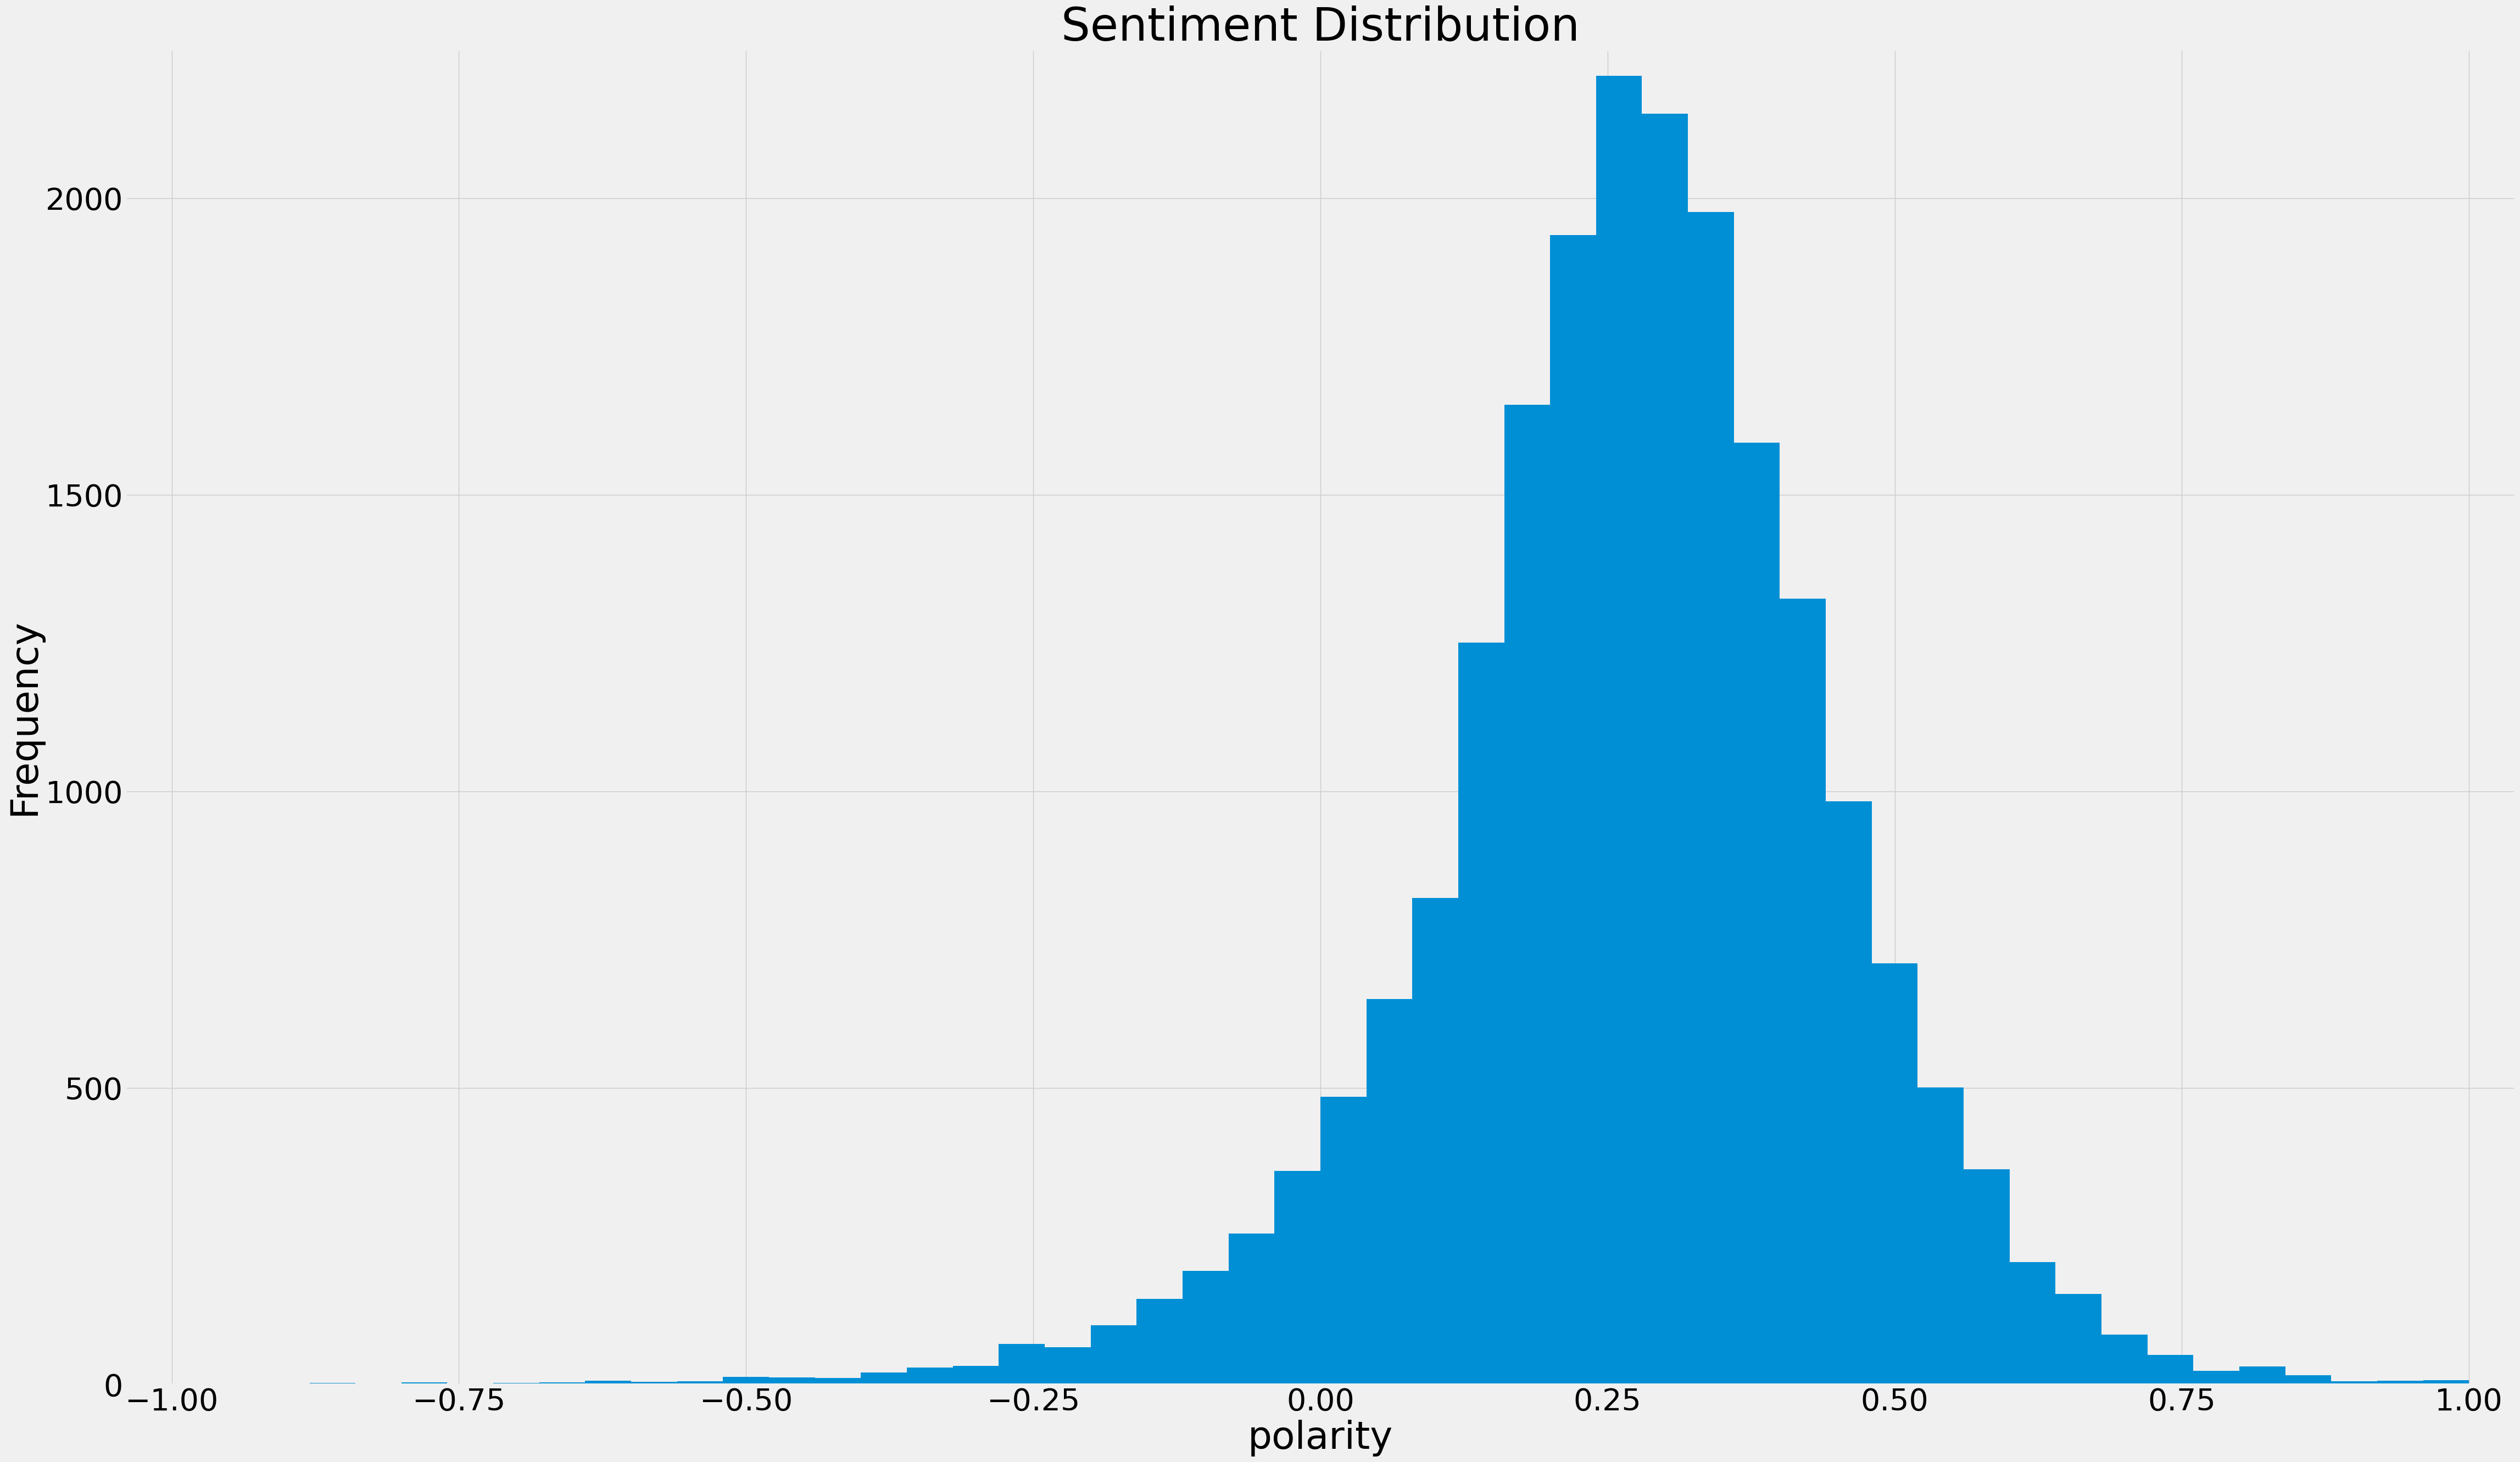

In [41]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('polarity', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(hotel_data['polarity'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

**We can see that the polarity is normally distributed in the data**

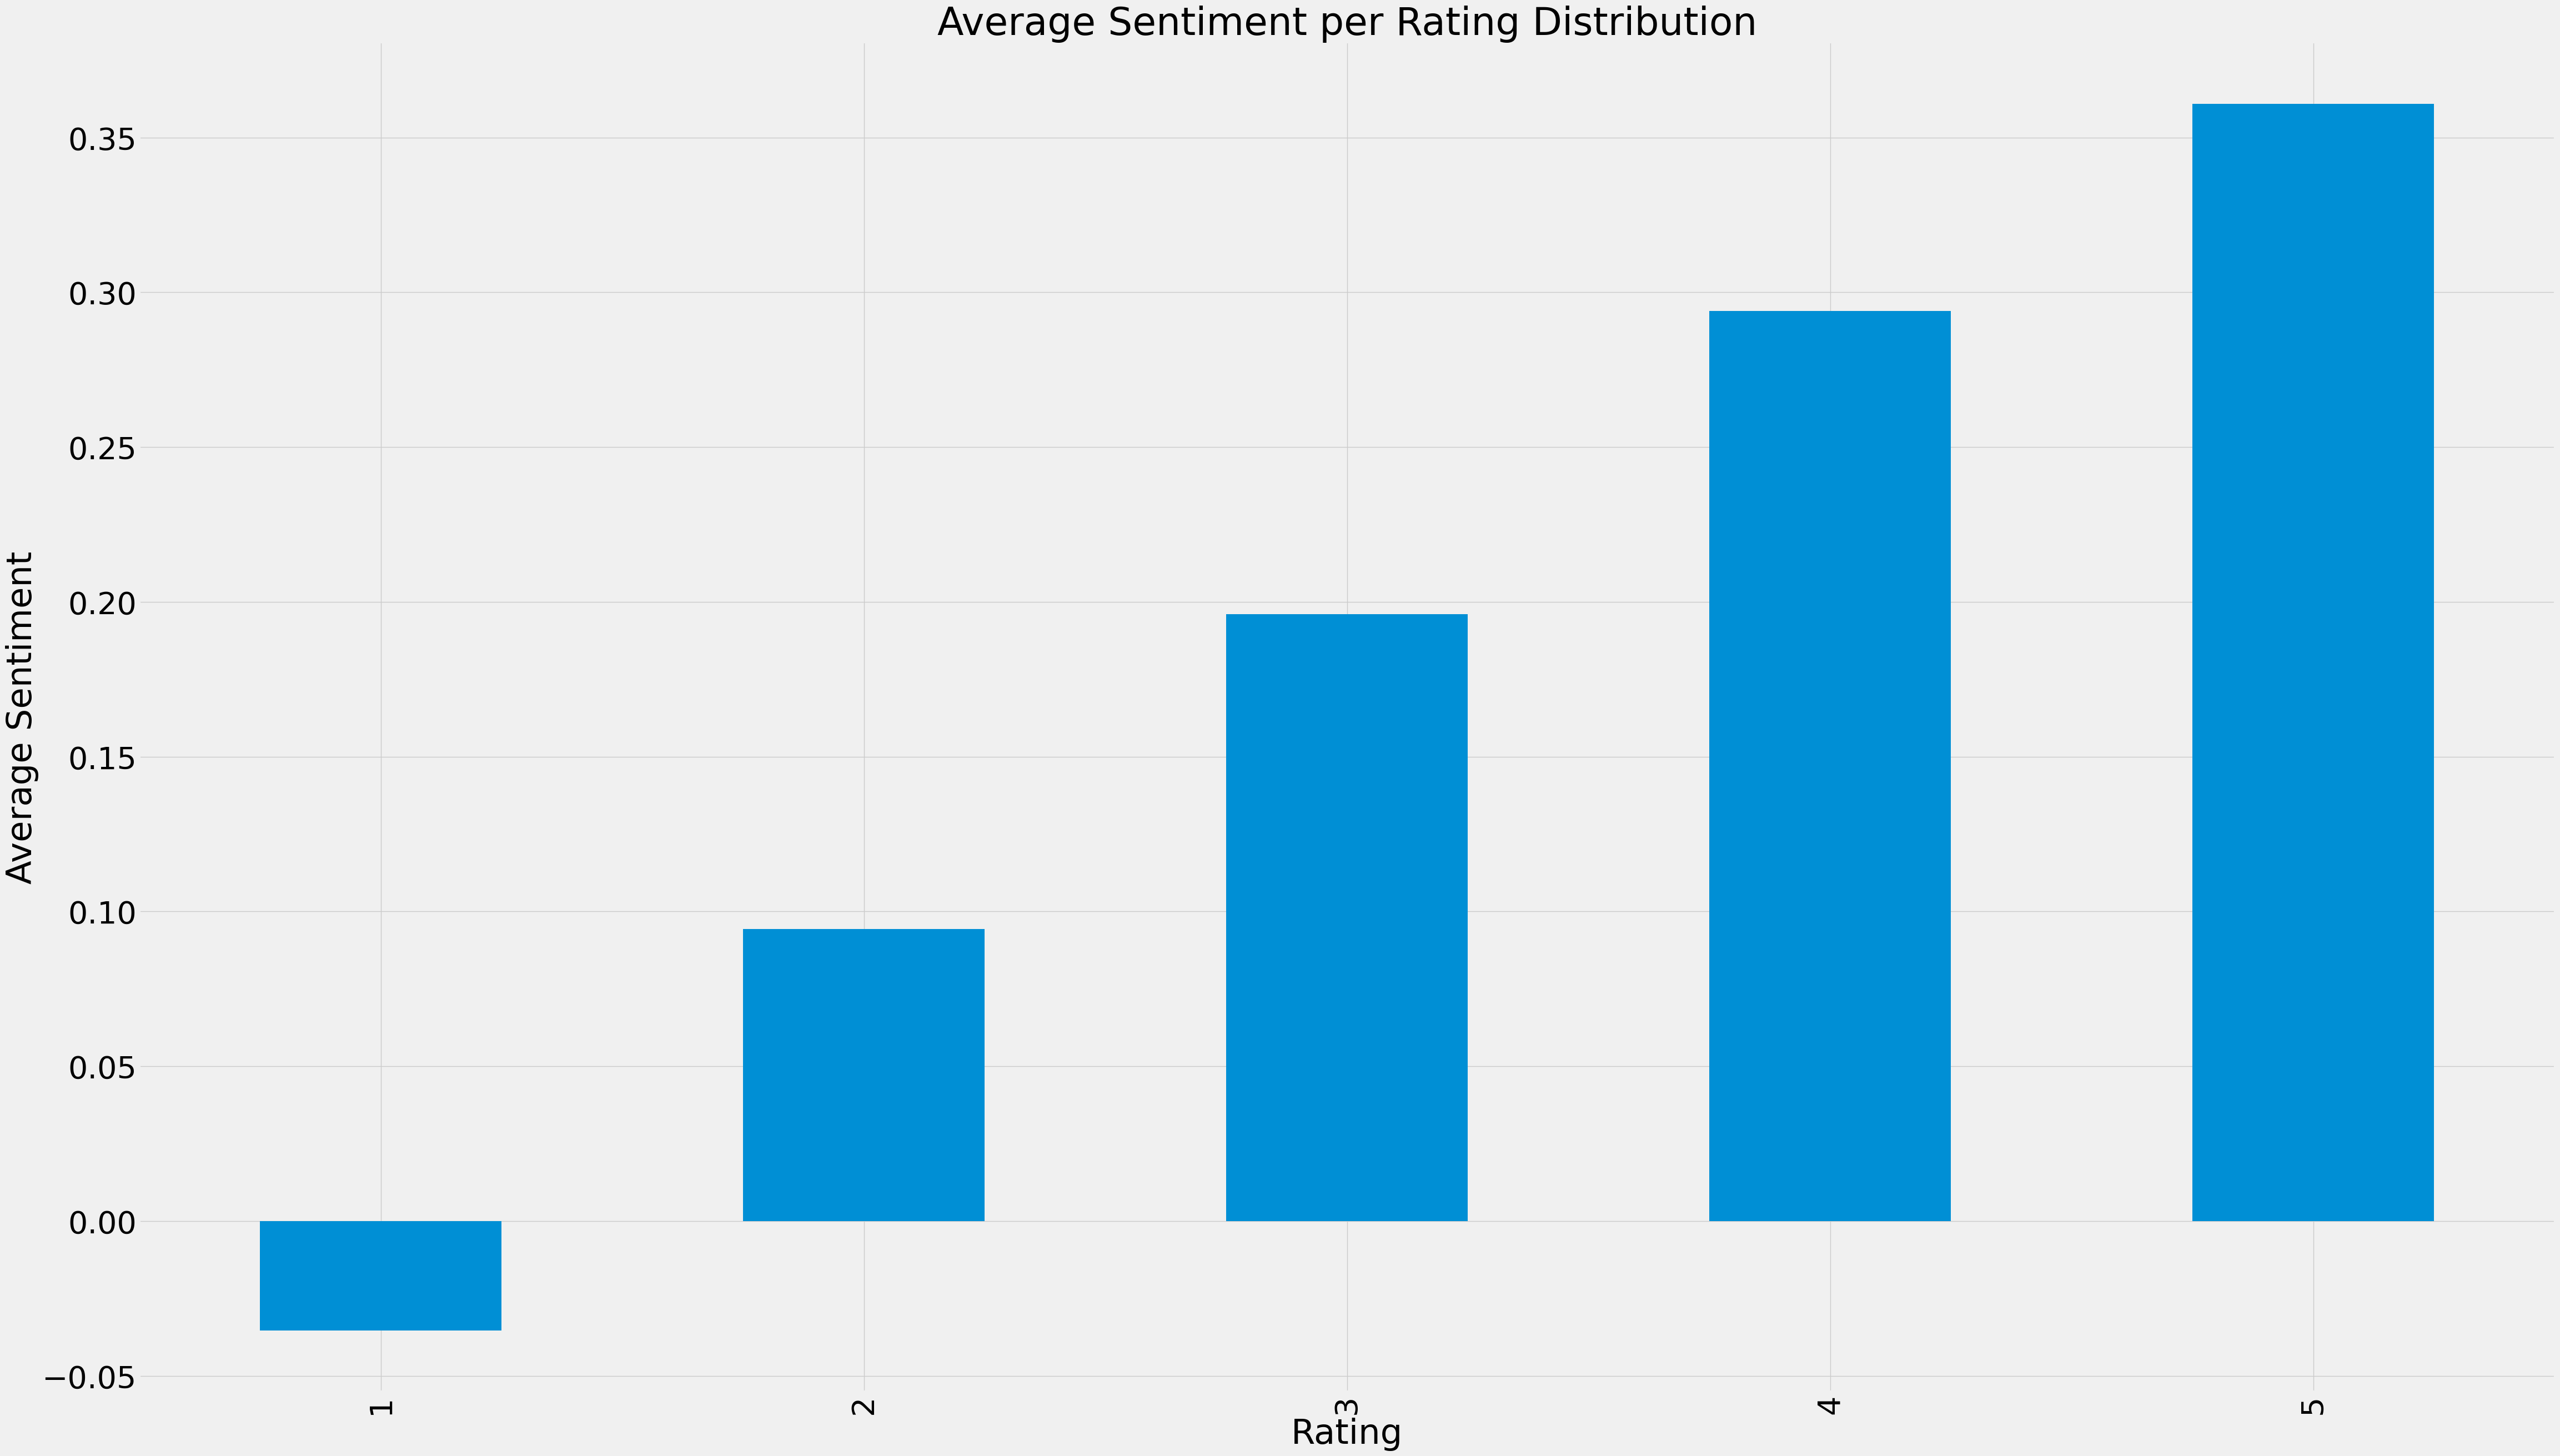

In [42]:
polarity_avg = hotel_data.groupby('Rating')['polarity'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()

**Here we can see that average polarity for 1 lies below zero. But for rest all,it starts from zero.And it increases as rating increases.**

## word Cloud

In [43]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

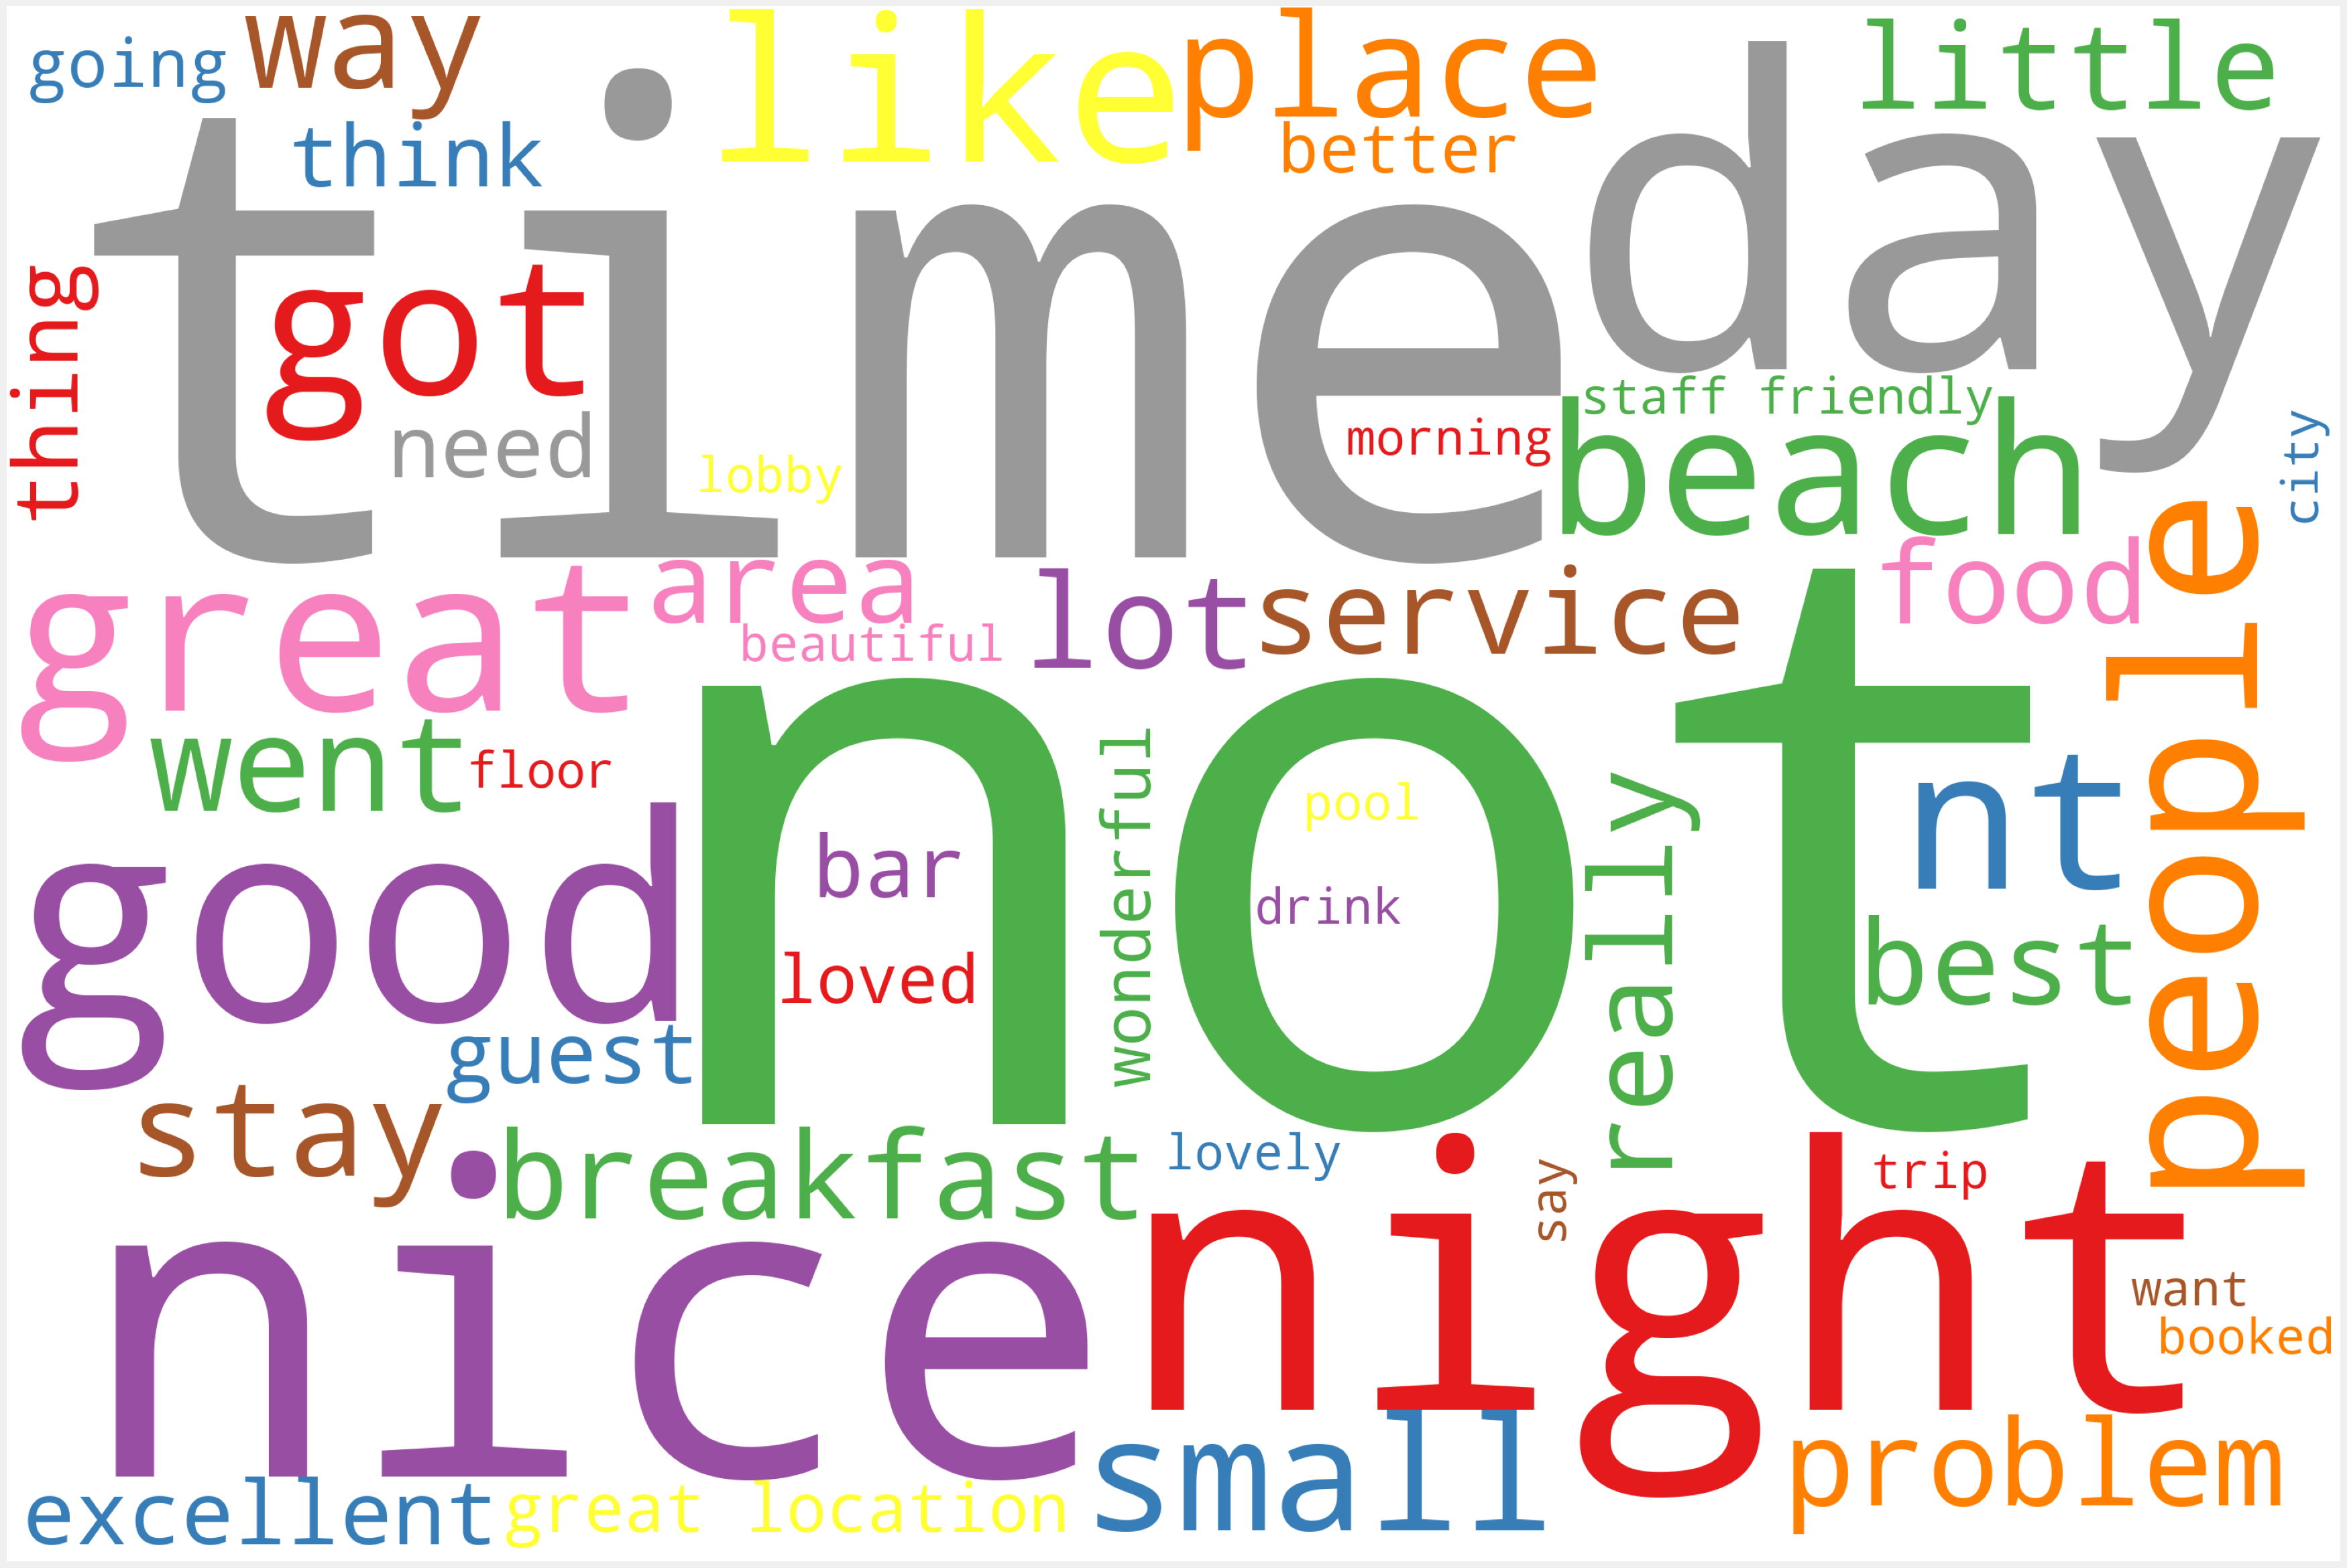

In [44]:
#Generate wordcloud
wordcloud=WordCloud(width=3000,height=2000,background_color='white',max_words=50,
                   colormap='Set1',stopwords=my_stop_words).generate(hotel_data['lemma_str'].str.cat(sep=" "))
plot_cloud(wordcloud)

### For positive sentiment

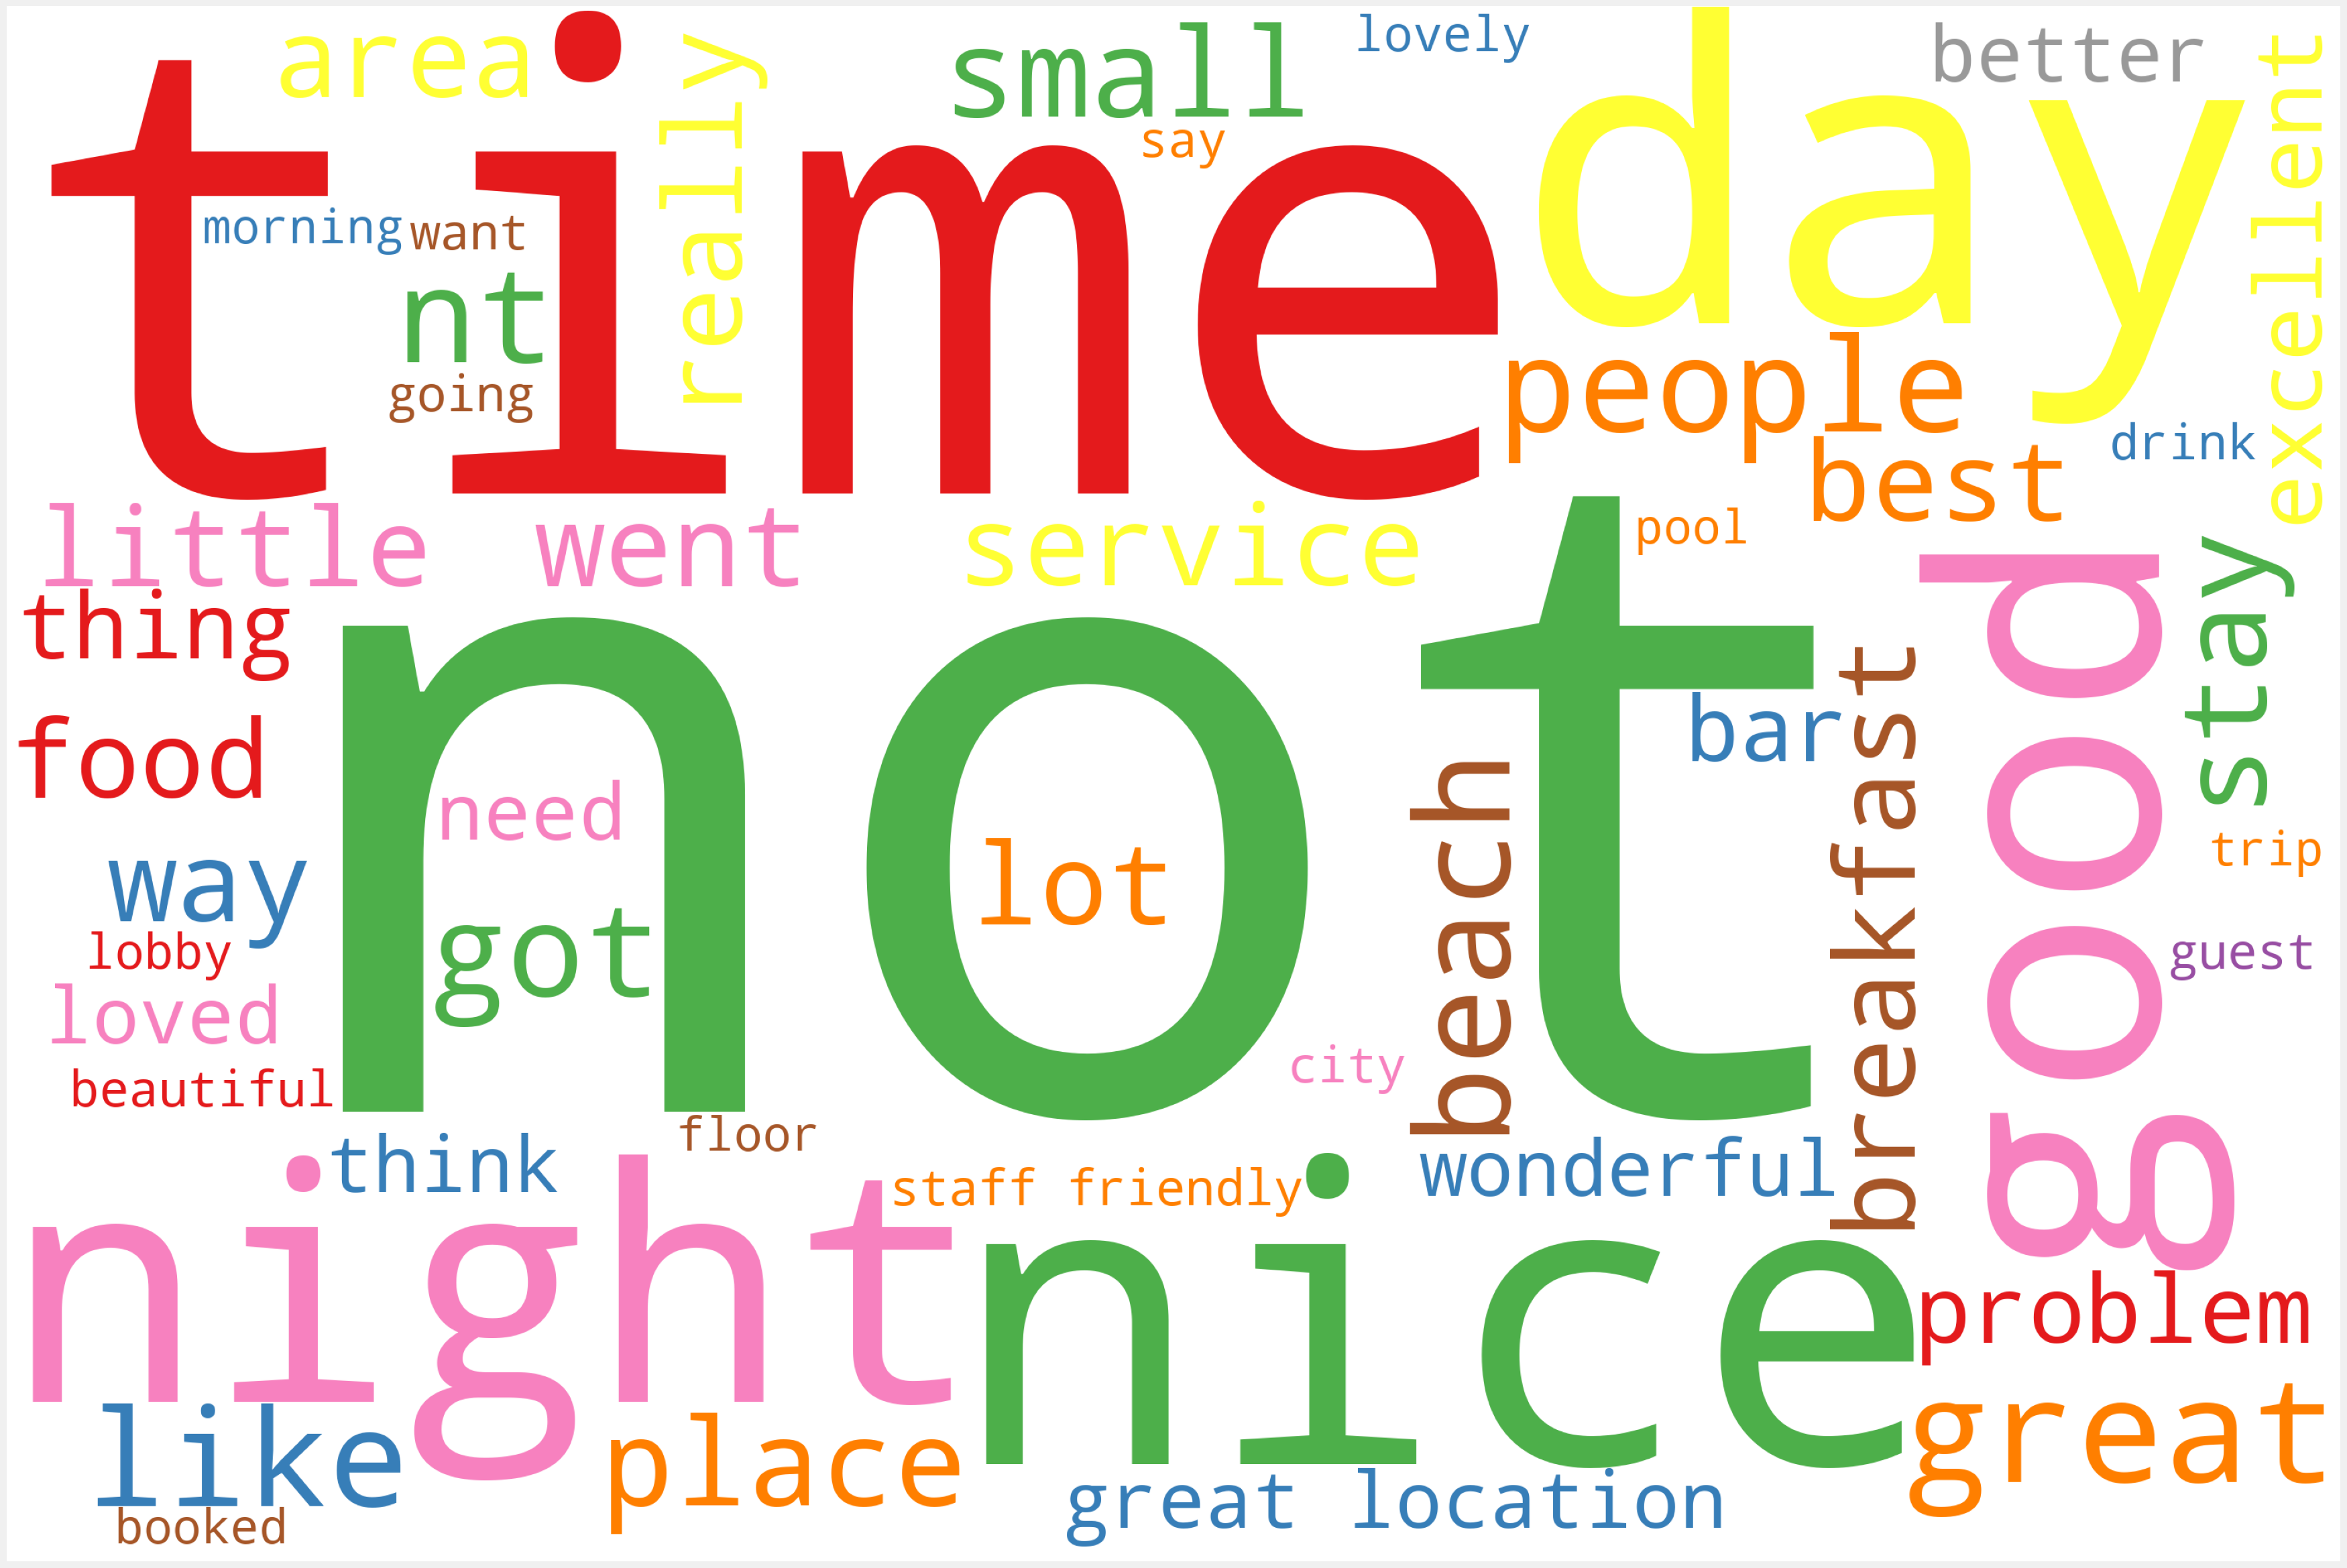

In [45]:
#Generate wordcloud
wordcloud_pos=WordCloud(width=3000,height=2000,background_color='white',max_words=50,
                   colormap='Set1',stopwords=my_stop_words).generate(hotel_data[hotel_data['sentiment']=='Positive']['lemma_str'].str.cat(sep=" "))
plot_cloud(wordcloud_pos)

### For neutral sentiment

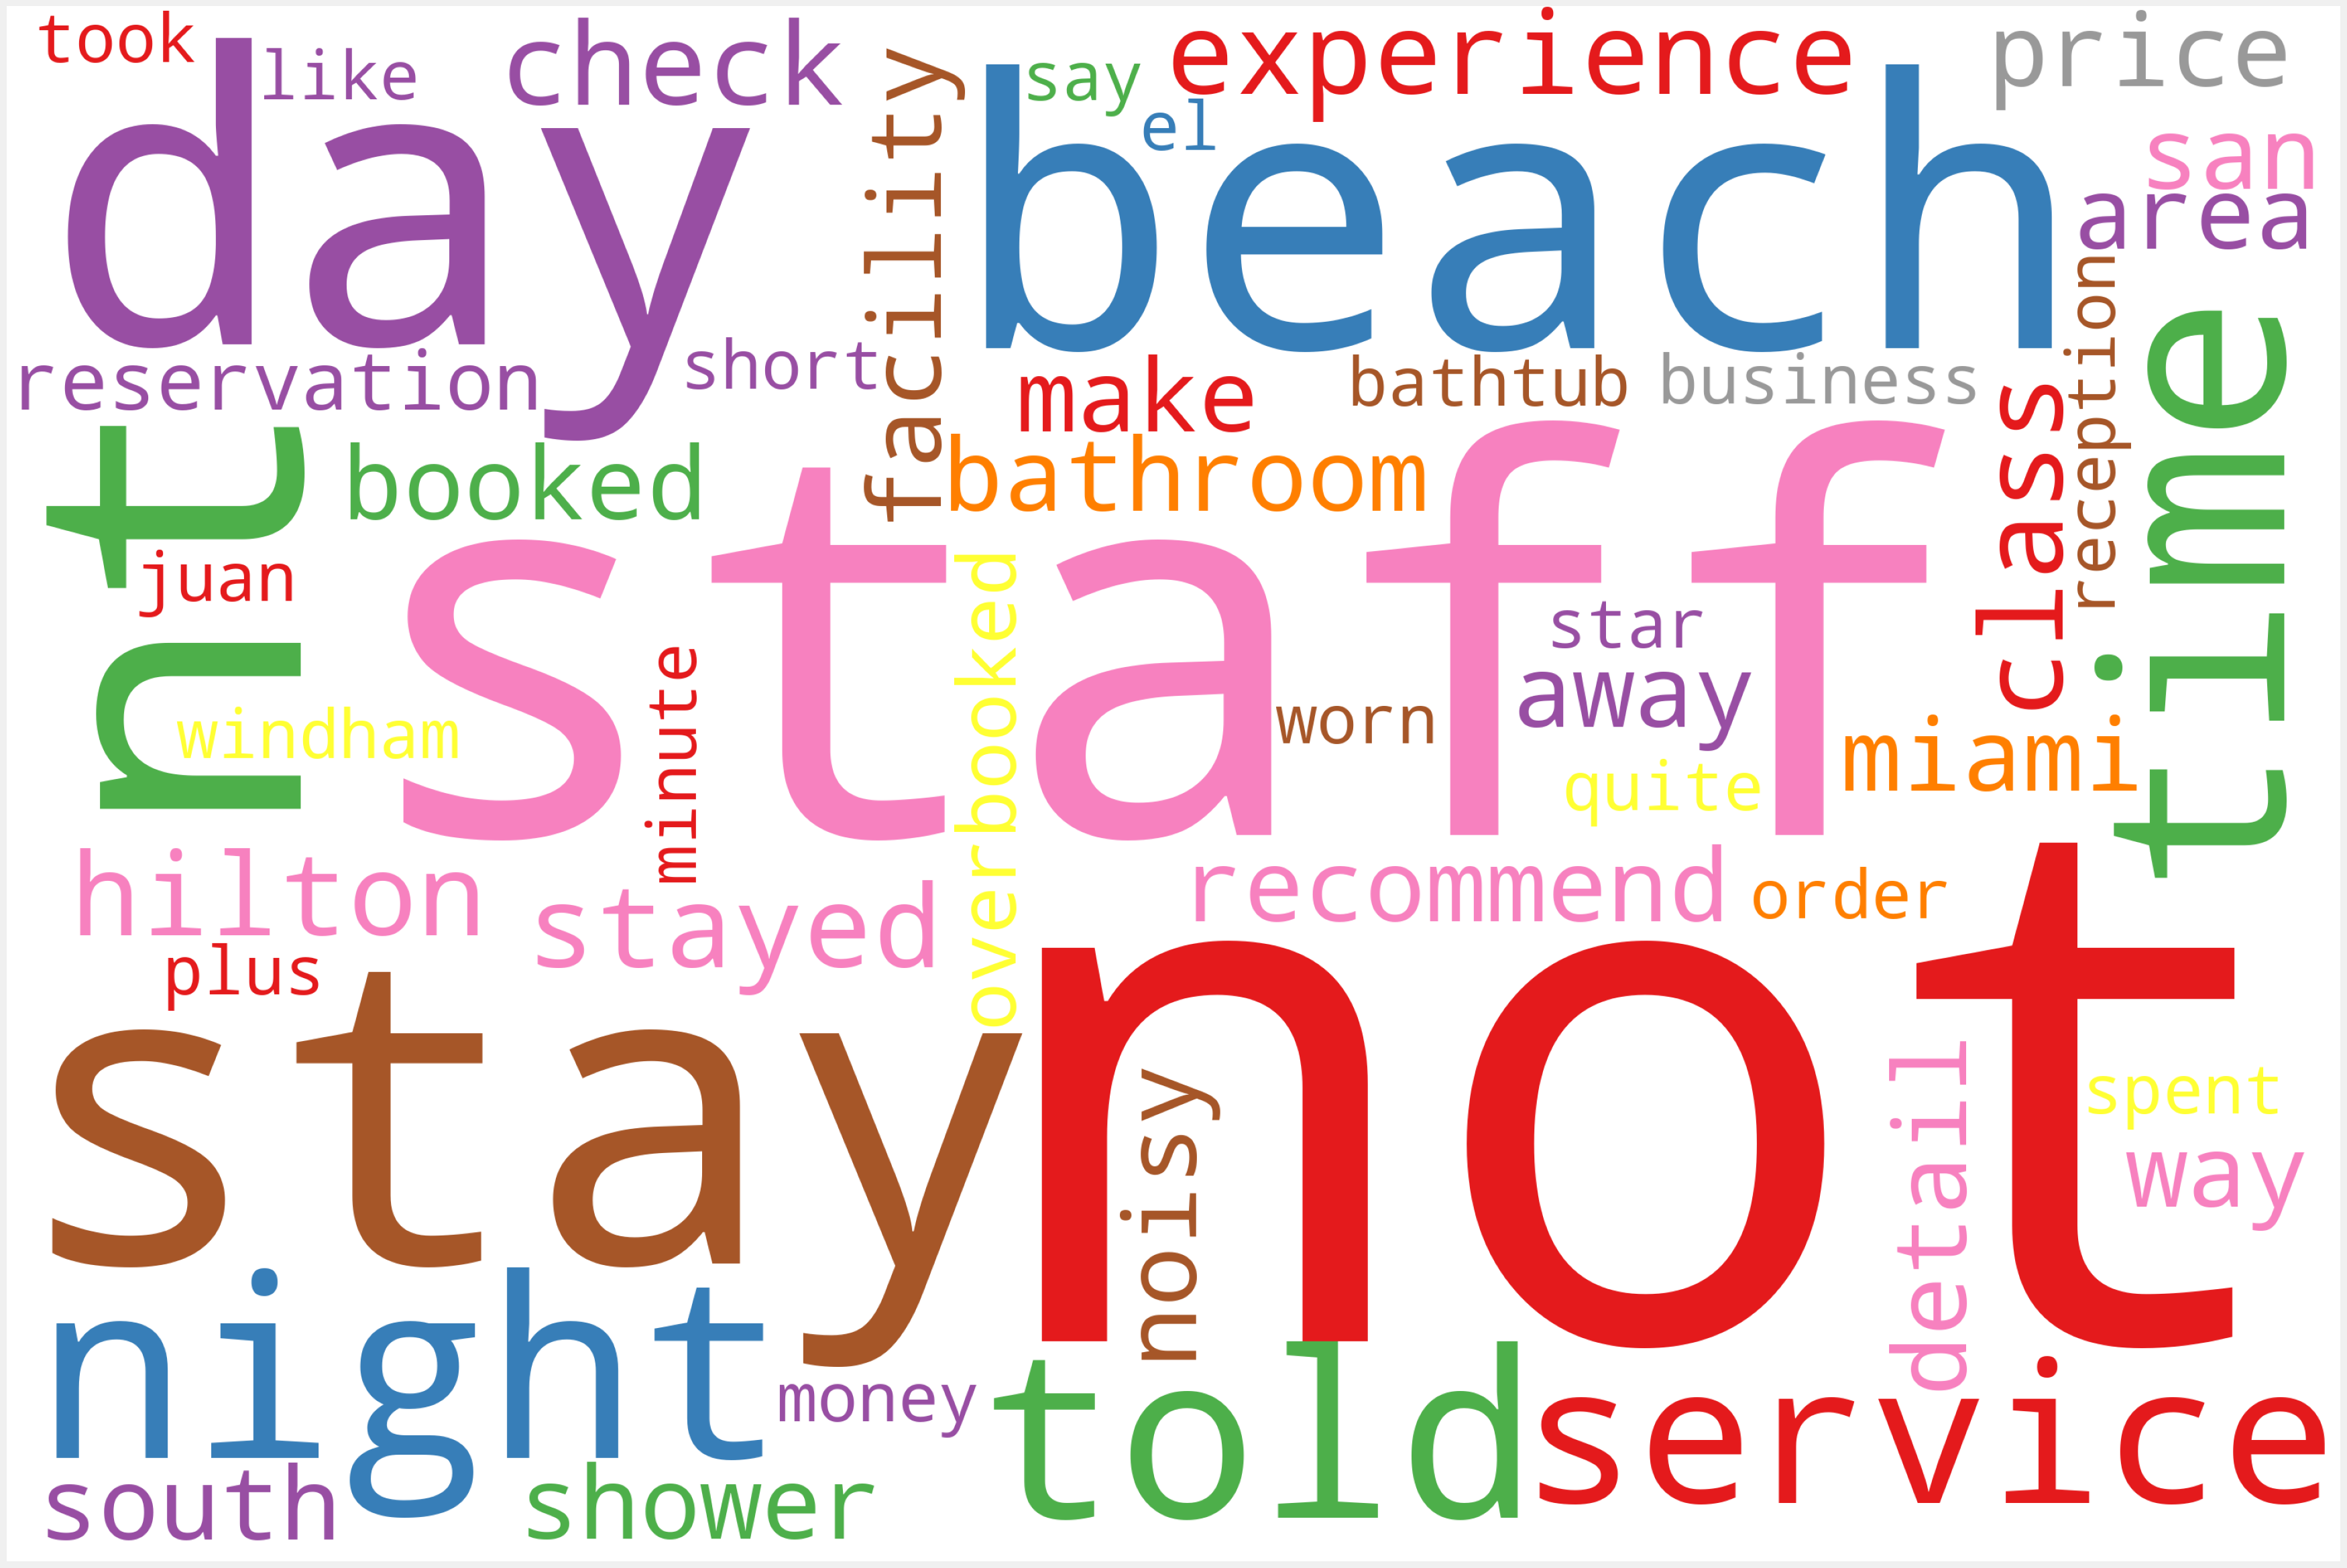

In [46]:
#Generate wordcloud
wordcloud_neutral=WordCloud(width=3000,height=2000,background_color='white',max_words=50,
                   colormap='Set1',stopwords=my_stop_words).generate(hotel_data[hotel_data['sentiment']=='Neutral']['lemma_str'].str.cat(sep=" "))
plot_cloud(wordcloud_neutral)

### For negative sentiment

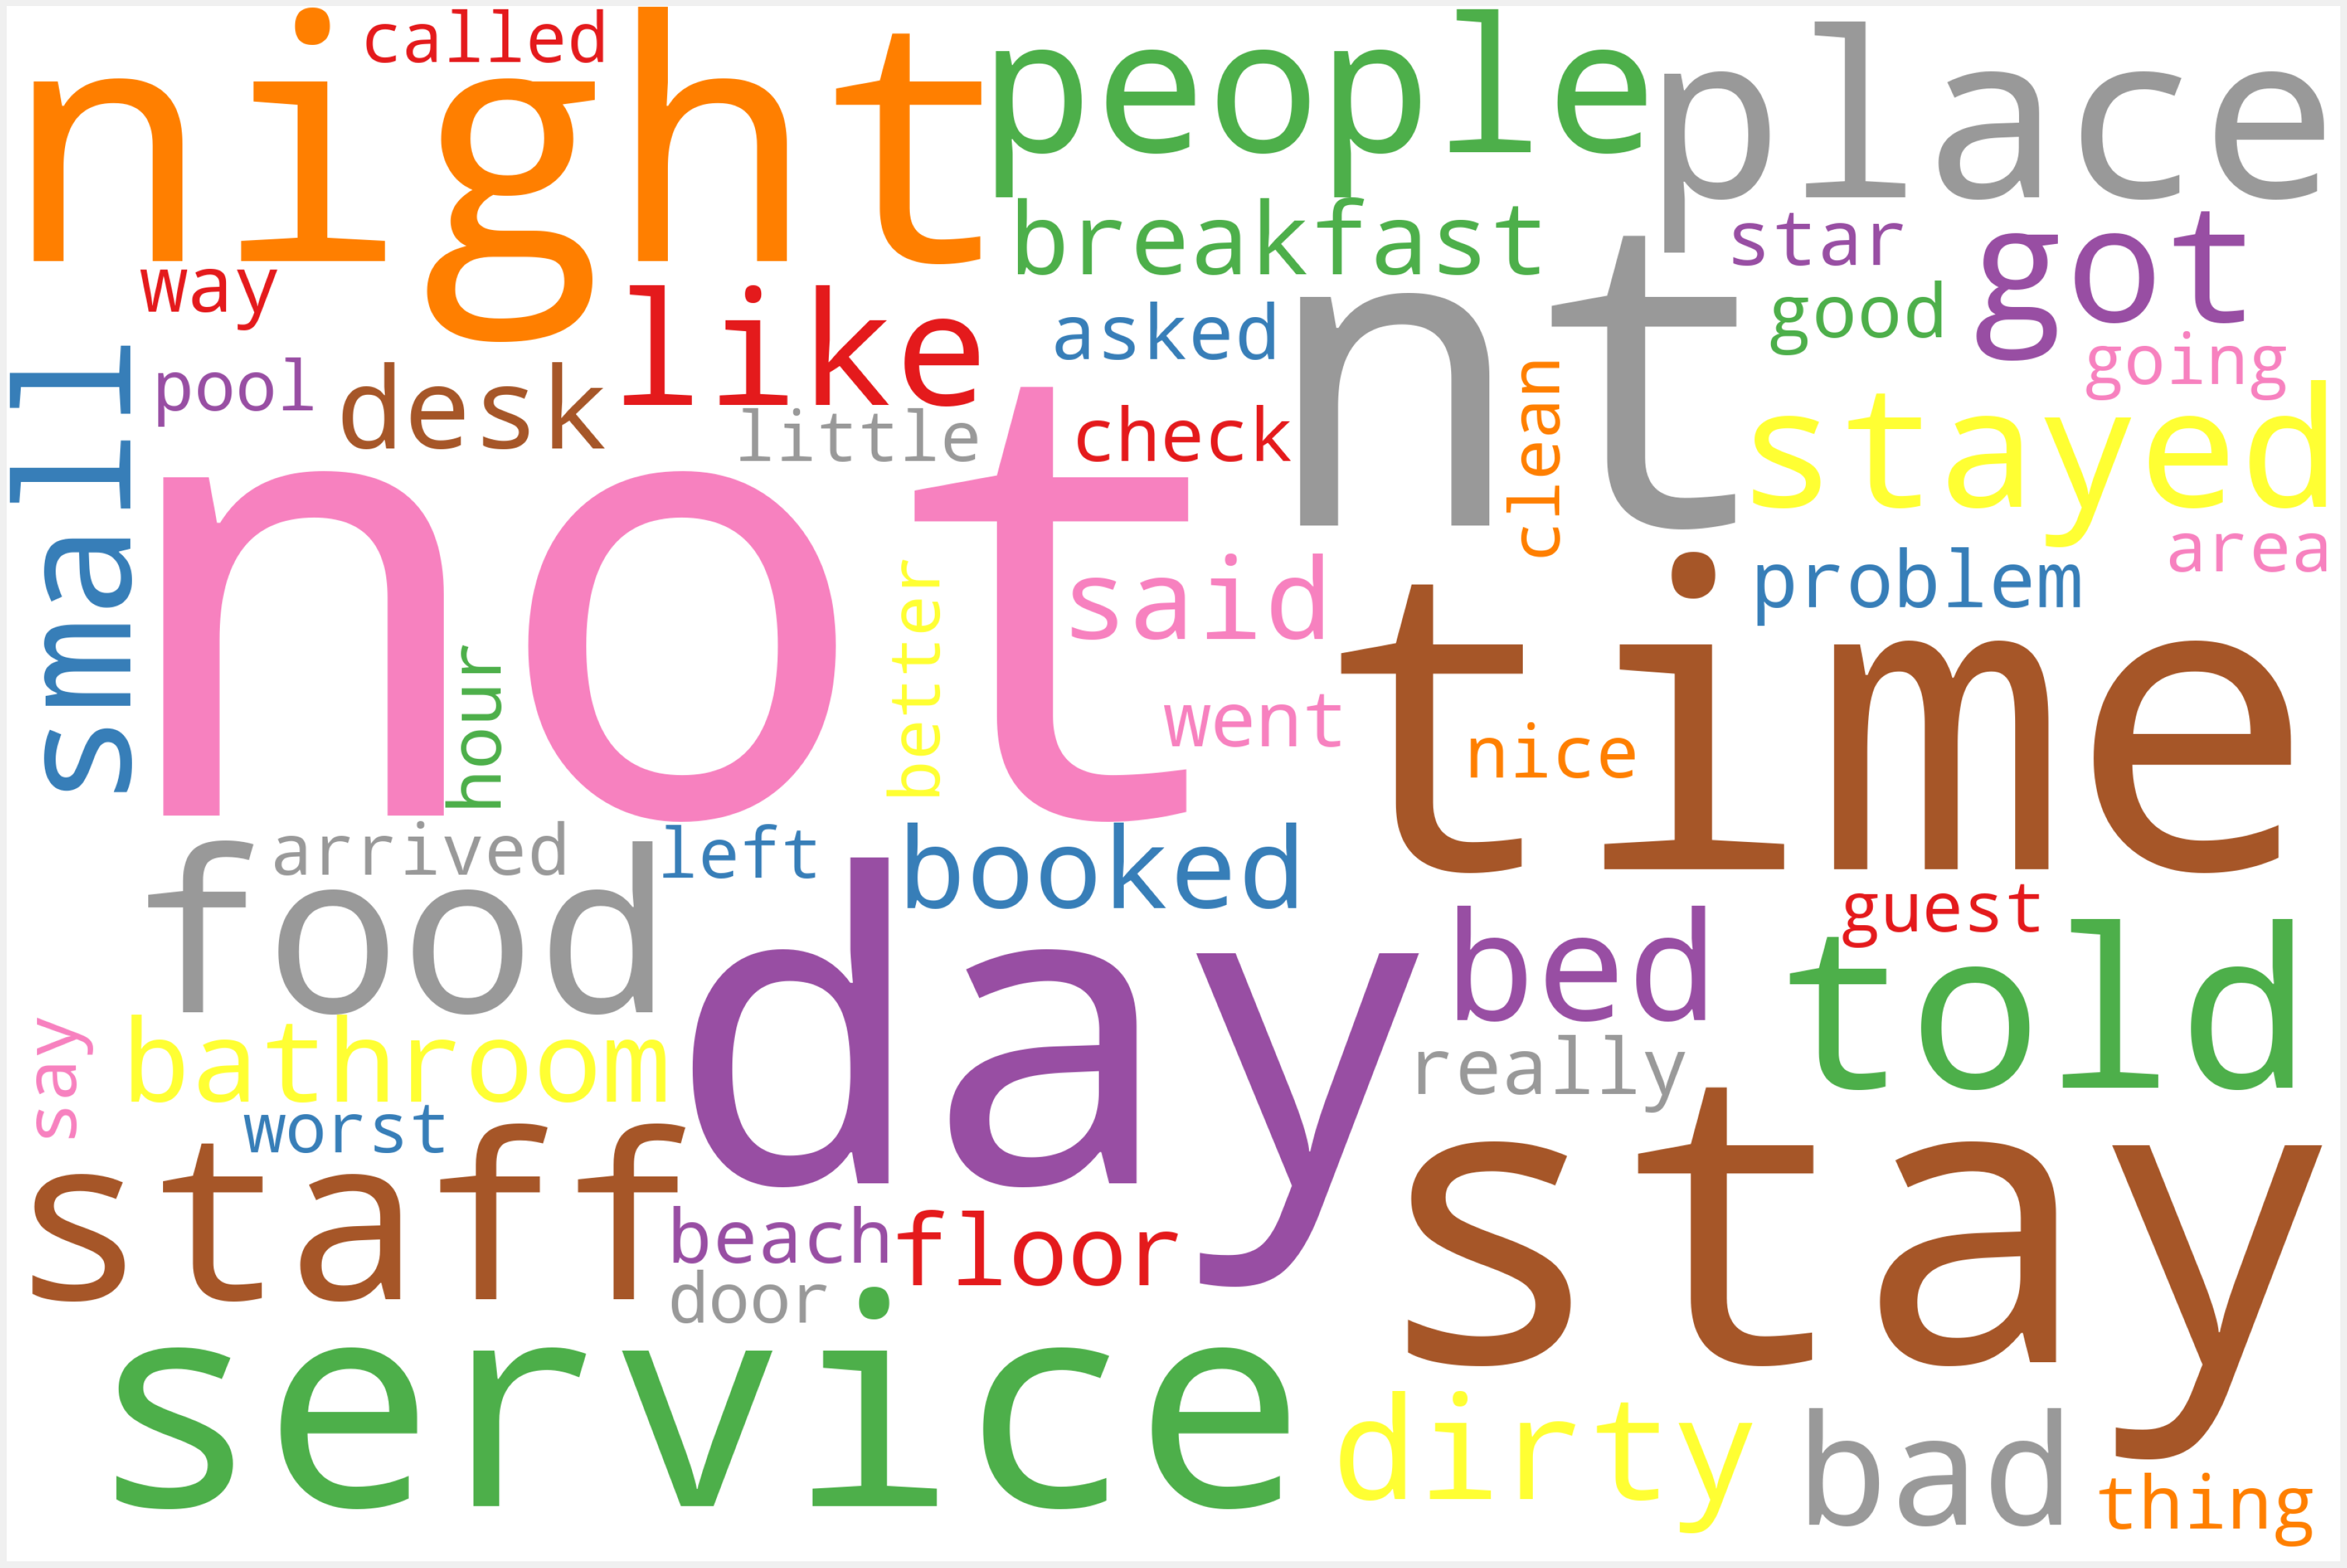

In [47]:
#Generate wordcloud
wordcloud_neg=WordCloud(width=3000,height=2000,background_color='white',max_words=50,
                   colormap='Set1',stopwords=my_stop_words).generate(hotel_data[hotel_data['sentiment']=='Negative']['lemma_str'].str.cat(sep=" "))
plot_cloud(wordcloud_neg)

## Feature Extraction

In [48]:
cv_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
cv = cv_vectorizer.fit_transform(hotel_data['lemma_str'].values.astype('U'))
cv_feature_names = cv_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(cv.toarray(), columns=list(cv_feature_names))
doc_term_matrix[50:60]

aaa  abc  ability  abit  able  abroad  absolute  absolutely  absolutley  \
50    0    0        0     0     0       0         0           0           0   
51    0    0        0     0     0       0         0           0           0   
52    0    0        0     0     0       0         0           1           0   
53    0    0        0     0     0       0         0           0           0   
54    0    0        0     0     0       0         0           0           0   
55    0    0        0     0     0       0         0           0           0   
56    0    0        0     0     0       0         0           0           0   
57    0    0        0     0     0       0         0           0           0   
58    0    0        0     0     0       0         0           0           0   
59    0    0        0     0     0       0         0           0           0   

    absolutly  ...  youçéèe  youçéêl  yr  yuck  yum  yummy  yunque  zero  \
50          0  ...        0        0   0     0    0      0       0     0   
51          0  ...        0        0   0     0    0      0       0     0   
52          0  ...        0        0   0     0    0      0       0     0   
53          0  ...        0        0   0     0    0      0       0     0   
54          0  ...        0        0   0     0    0      0       0     0   
55          0  ...        0        0   0     0    0      0       0     0   
56          0  ...        0        0   0     0    0      0       0     0   
57          0  ...        0        0   0     0    0      0       0     0   
58          0  ...        0        0   0     0    0      0       0     0   
59          0  ...        0        0   0     0    0      0       0     0   

    zone  zoo  
50     0    0  
51     0    0  
52     0    0  
53     0    0  
54     0    0  
55     0    0  
56     0    0  
57     0    0  
58     0    0  
59     0    0  

[10 rows x 4957 columns]

## TF IDF vectoriser

In [49]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=25, max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(hotel_data['lemma_str'].values.astype('U'))
tf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tfidf.toarray(), columns=list(tf_feature_names))
doc_term_matrix[50:60]

aaa  abc  ability  abit  able  abroad  absolute  absolutely  absolutley  \
50  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   
51  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   
52  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.12241         0.0   
53  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   
54  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   
55  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   
56  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   
57  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   
58  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   
59  0.0  0.0      0.0   0.0   0.0     0.0       0.0     0.00000         0.0   

    absolutly  ...  youçéèe  youçéêl   yr  yuck  yum  yummy  yunque  zero  \
50        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
51        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
52        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
53        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
54        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
55        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
56        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
57        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
58        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   
59        0.0  ...      0.0      0.0  0.0   0.0  0.0    0.0     0.0   0.0   

    zone  zoo  
50   0.0  0.0  
51   0.0  0.0  
52   0.0  0.0  
53   0.0  0.0  
54   0.0  0.0  
55   0.0  0.0  
56   0.0  0.0  
57   0.0  0.0  
58   0.0  0.0  
59   0.0  0.0  

[10 rows x 4957 columns]

## Named Entity Recognition

In [50]:
nlp = spacy.load('en_core_web_sm')

one_block = hotel_data['lemma_str'][2]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block, style='ent', jupyter=True)

In [51]:
one_block

'nice room not experience monaco seattle good nt levelpositives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized missed separate wakeup call concierge busy hard touch nt provide guidance special requeststv hard use ipod sound dock suite non functioning decided book mediterranean suite night weekend stay choice rest party filled comparison w spent night larger square footage great soaking tub whirlpool jet nice showerbefore stay arrange car service price tip reasonable driver waiting arrivalcheckin easy downside picked person jacuzi tub bath accessory salt bubble bath nt stay night got checked voucher bottle champagne nice gesture fish waiting impression huge open space felt big tv far away bed chore change channel ipod dock broken disappointingin morning way asked desk check thermostat said degree warm try cover face night bright blue light kept got night drop desk called maintainence came look 

In [52]:
doc_block

nice room not experience monaco seattle good nt levelpositives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized missed separate wakeup call concierge busy hard touch nt provide guidance special requeststv hard use ipod sound dock suite non functioning decided book mediterranean suite night weekend stay choice rest party filled comparison w spent night larger square footage great soaking tub whirlpool jet nice showerbefore stay arrange car service price tip reasonable driver waiting arrivalcheckin easy downside picked person jacuzi tub bath accessory salt bubble bath nt stay night got checked voucher bottle champagne nice gesture fish waiting impression huge open space felt big tv far away bed chore change channel ipod dock broken disappointingin morning way asked desk check thermostat said degree warm try cover face night bright blue light kept got night drop desk called maintainence came look t

In [53]:
for token in doc_block[0:20]:
    print(token, token.pos_)

nice ADJ
room NOUN
not PART
experience VERB
monaco PROPN
seattle PROPN
good NOUN
nt PART
levelpositives VERB
large ADJ
bathroom NOUN
mediterranean PROPN
suite NOUN
comfortable ADJ
bed NOUN
pillowsattentive VERB
housekeeping NOUN
staffnegatives NOUN
ac PROPN
unit NOUN


In [54]:
#Filtering for nouns and verbs only
nouns_verbs = [token.text for token in doc_block if token.pos_ in ('NOUN', 'VERB')]
print(nouns_verbs[5:25])

['suite', 'bed', 'pillowsattentive', 'housekeeping', 'staffnegatives', 'unit', 'malfunctioned', 'stay', 'desk', 'missed', 'wakeup', 'call', 'concierge', 'touch', 'provide', 'guidance', 'requeststv', 'use', 'dock', 'suite']


In [55]:
cv = CountVectorizer()

X = cv.fit_transform(nouns_verbs)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
wf_df = pd.DataFrame(words_freq)
wf_df.columns = ['word', 'count']

wf_df[0:10]

word  count
0      stay      4
1     night      4
2      desk      3
3      bath      3
4   morning      3
5  bathroom      2
6     suite      2
7       bed      2
8       jet      2
9   waiting      2

<AxesSubplot:title={'center':'Top verbs and nouns'}, xlabel='word'>

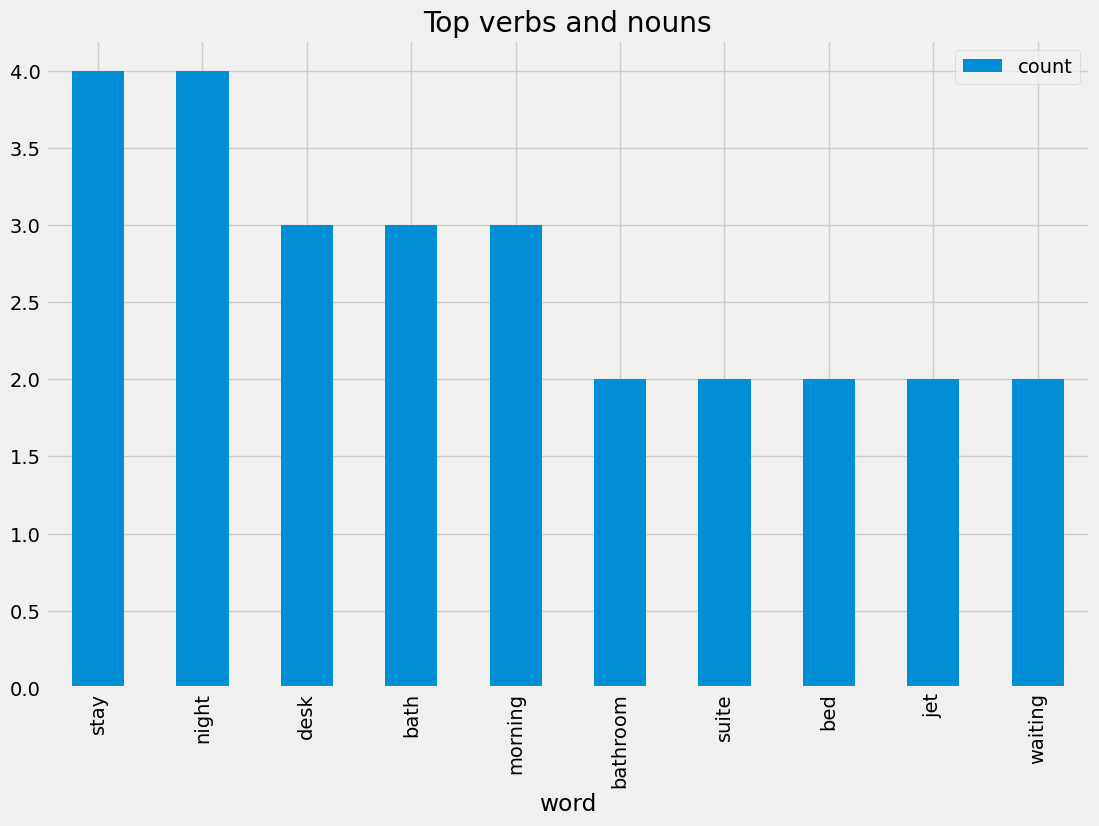

In [56]:
##Visualizing results
#Barchart for top 10 nouns + verbs
wf_df[0:10].plot.bar(x='word', figsize=(12,8), title='Top verbs and nouns')

In [57]:
hotel_data['word_count'] = hotel_data['lemmatized'].apply(lambda x: len(str(x).split()))
hotel_data['review_len'] = hotel_data['lemma_str'].astype(str).apply(len)
hotel_data.head()

Rating                                         lemmatized  \
0       4  [nice, expensive, parking, got, good, deal, st...   
1       2  [ok, nothing, special, charge, diamond, member...   
2       3  [nice, room, not, experience, monaco, seattle,...   
3       5  [unique, great, stay, wonderful, time, monaco,...   
4       5  [great, stay, great, stay, went, seahawk, game...   

                                           lemma_str  polarity  subjectivity  \
0  nice expensive parking got good deal stay anni...  0.208744      0.687000   
1  ok nothing special charge diamond member hilto...  0.227204      0.523295   
2  nice room not experience monaco seattle good n...  0.294420      0.605208   
3  unique great stay wonderful time monaco locati...  0.504825      0.691228   
4  great stay great stay went seahawk game awesom...  0.389286      0.627296   

  sentiment  word_count  review_len  
0  Positive          77         523  
1  Positive         224        1534  
2  Positive         185        1252  
3  Positive          80         533  
4  Positive         176        1157

In [58]:
hotel_data.sort_values(by='review_len',ascending=False)

Rating                                         lemmatized  \
7072        3  [honest, review, visit, let, begin, saying, he...   
7049        5  [false, start, good, vacation, secretsç, false...   
13003       5  [awesome, vacation, sirenis, punta, cana, arri...   
17777       5  [fantastic, return, trip, firstly, apology, le...   
17800       4  [wanted, know, afraid, ask, short, day, ago, n...   
...       ...                                                ...   
15273       4  [nice, fight, good, view, view, finally, got, ...   
488         3  [issue, nt, say, star, service, great, pool, bar]   
12823       3     [beach, beautiful, sunset, small, beach, area]   
1501        5           [loved, amazing, space, lot, not, bored]   
18073       5                    [nice, view, second, left, row]   

                                               lemma_str  polarity  \
7072   honest review visit let begin saying heard sec...  0.118585   
7049   false start good vacation secretsç false start...  0.120662   
13003  awesome vacation sirenis punta cana arrival fl...  0.171920   
17777  fantastic return trip firstly apology length r...  0.294211   
17800  wanted know afraid ask short day ago nervously...  0.114675   
...                                                  ...       ...   
15273        nice fight good view view finally got moved  0.433333   
488             issue nt say star service great pool bar  0.800000   
12823            beach beautiful sunset small beach area  0.300000   
1501                   loved amazing space lot not bored  0.516667   
18073                          nice view second left row  0.200000   

       subjectivity sentiment  word_count  review_len  
7072       0.545609  Positive        1829       12407  
7049       0.496123  Positive        1618       11000  
13003      0.567114  Positive        1514        9948  
17777      0.574443  Positive        1472        9460  
17800      0.487766  Positive        1338        8974  
...             ...       ...         ...         ...  
15273      0.866667  Positive           8          43  
488        0.750000  Positive           8          40  
12823      0.700000  Positive           6          39  
1501       0.900000  Positive           6          33  
18073      0.333333  Positive           5          25  

[20491 rows x 8 columns]

In [59]:
hotel_data.sort_values(by='word_count',ascending=False)

Rating                                         lemmatized  \
7072        3  [honest, review, visit, let, begin, saying, he...   
7049        5  [false, start, good, vacation, secretsç, false...   
13003       5  [awesome, vacation, sirenis, punta, cana, arri...   
17777       5  [fantastic, return, trip, firstly, apology, le...   
17800       4  [wanted, know, afraid, ask, short, day, ago, n...   
...       ...                                                ...   
488         3  [issue, nt, say, star, service, great, pool, bar]   
16736       4  [clean, attentive, welcoming, staff, infinity,...   
12823       3     [beach, beautiful, sunset, small, beach, area]   
1501        5           [loved, amazing, space, lot, not, bored]   
18073       5                    [nice, view, second, left, row]   

                                               lemma_str  polarity  \
7072   honest review visit let begin saying heard sec...  0.118585   
7049   false start good vacation secretsç false start...  0.120662   
13003  awesome vacation sirenis punta cana arrival fl...  0.171920   
17777  fantastic return trip firstly apology length r...  0.294211   
17800  wanted know afraid ask short day ago nervously...  0.114675   
...                                                  ...       ...   
488             issue nt say star service great pool bar  0.800000   
16736  clean attentive welcoming staff infinity pool ...  0.255556   
12823            beach beautiful sunset small beach area  0.300000   
1501                   loved amazing space lot not bored  0.516667   
18073                          nice view second left row  0.200000   

       subjectivity sentiment  word_count  review_len  
7072       0.545609  Positive        1829       12407  
7049       0.496123  Positive        1618       11000  
13003      0.567114  Positive        1514        9948  
17777      0.574443  Positive        1472        9460  
17800      0.487766  Positive        1338        8974  
...             ...       ...         ...         ...  
488        0.750000  Positive           8          40  
16736      0.533333  Positive           8          55  
12823      0.700000  Positive           6          39  
1501       0.900000  Positive           6          33  
18073      0.333333  Positive           5          25  

[20491 rows x 8 columns]

**Positive sentiments have more review length as well as more word count. We can say that people who are happy with the reviews write long reviews**

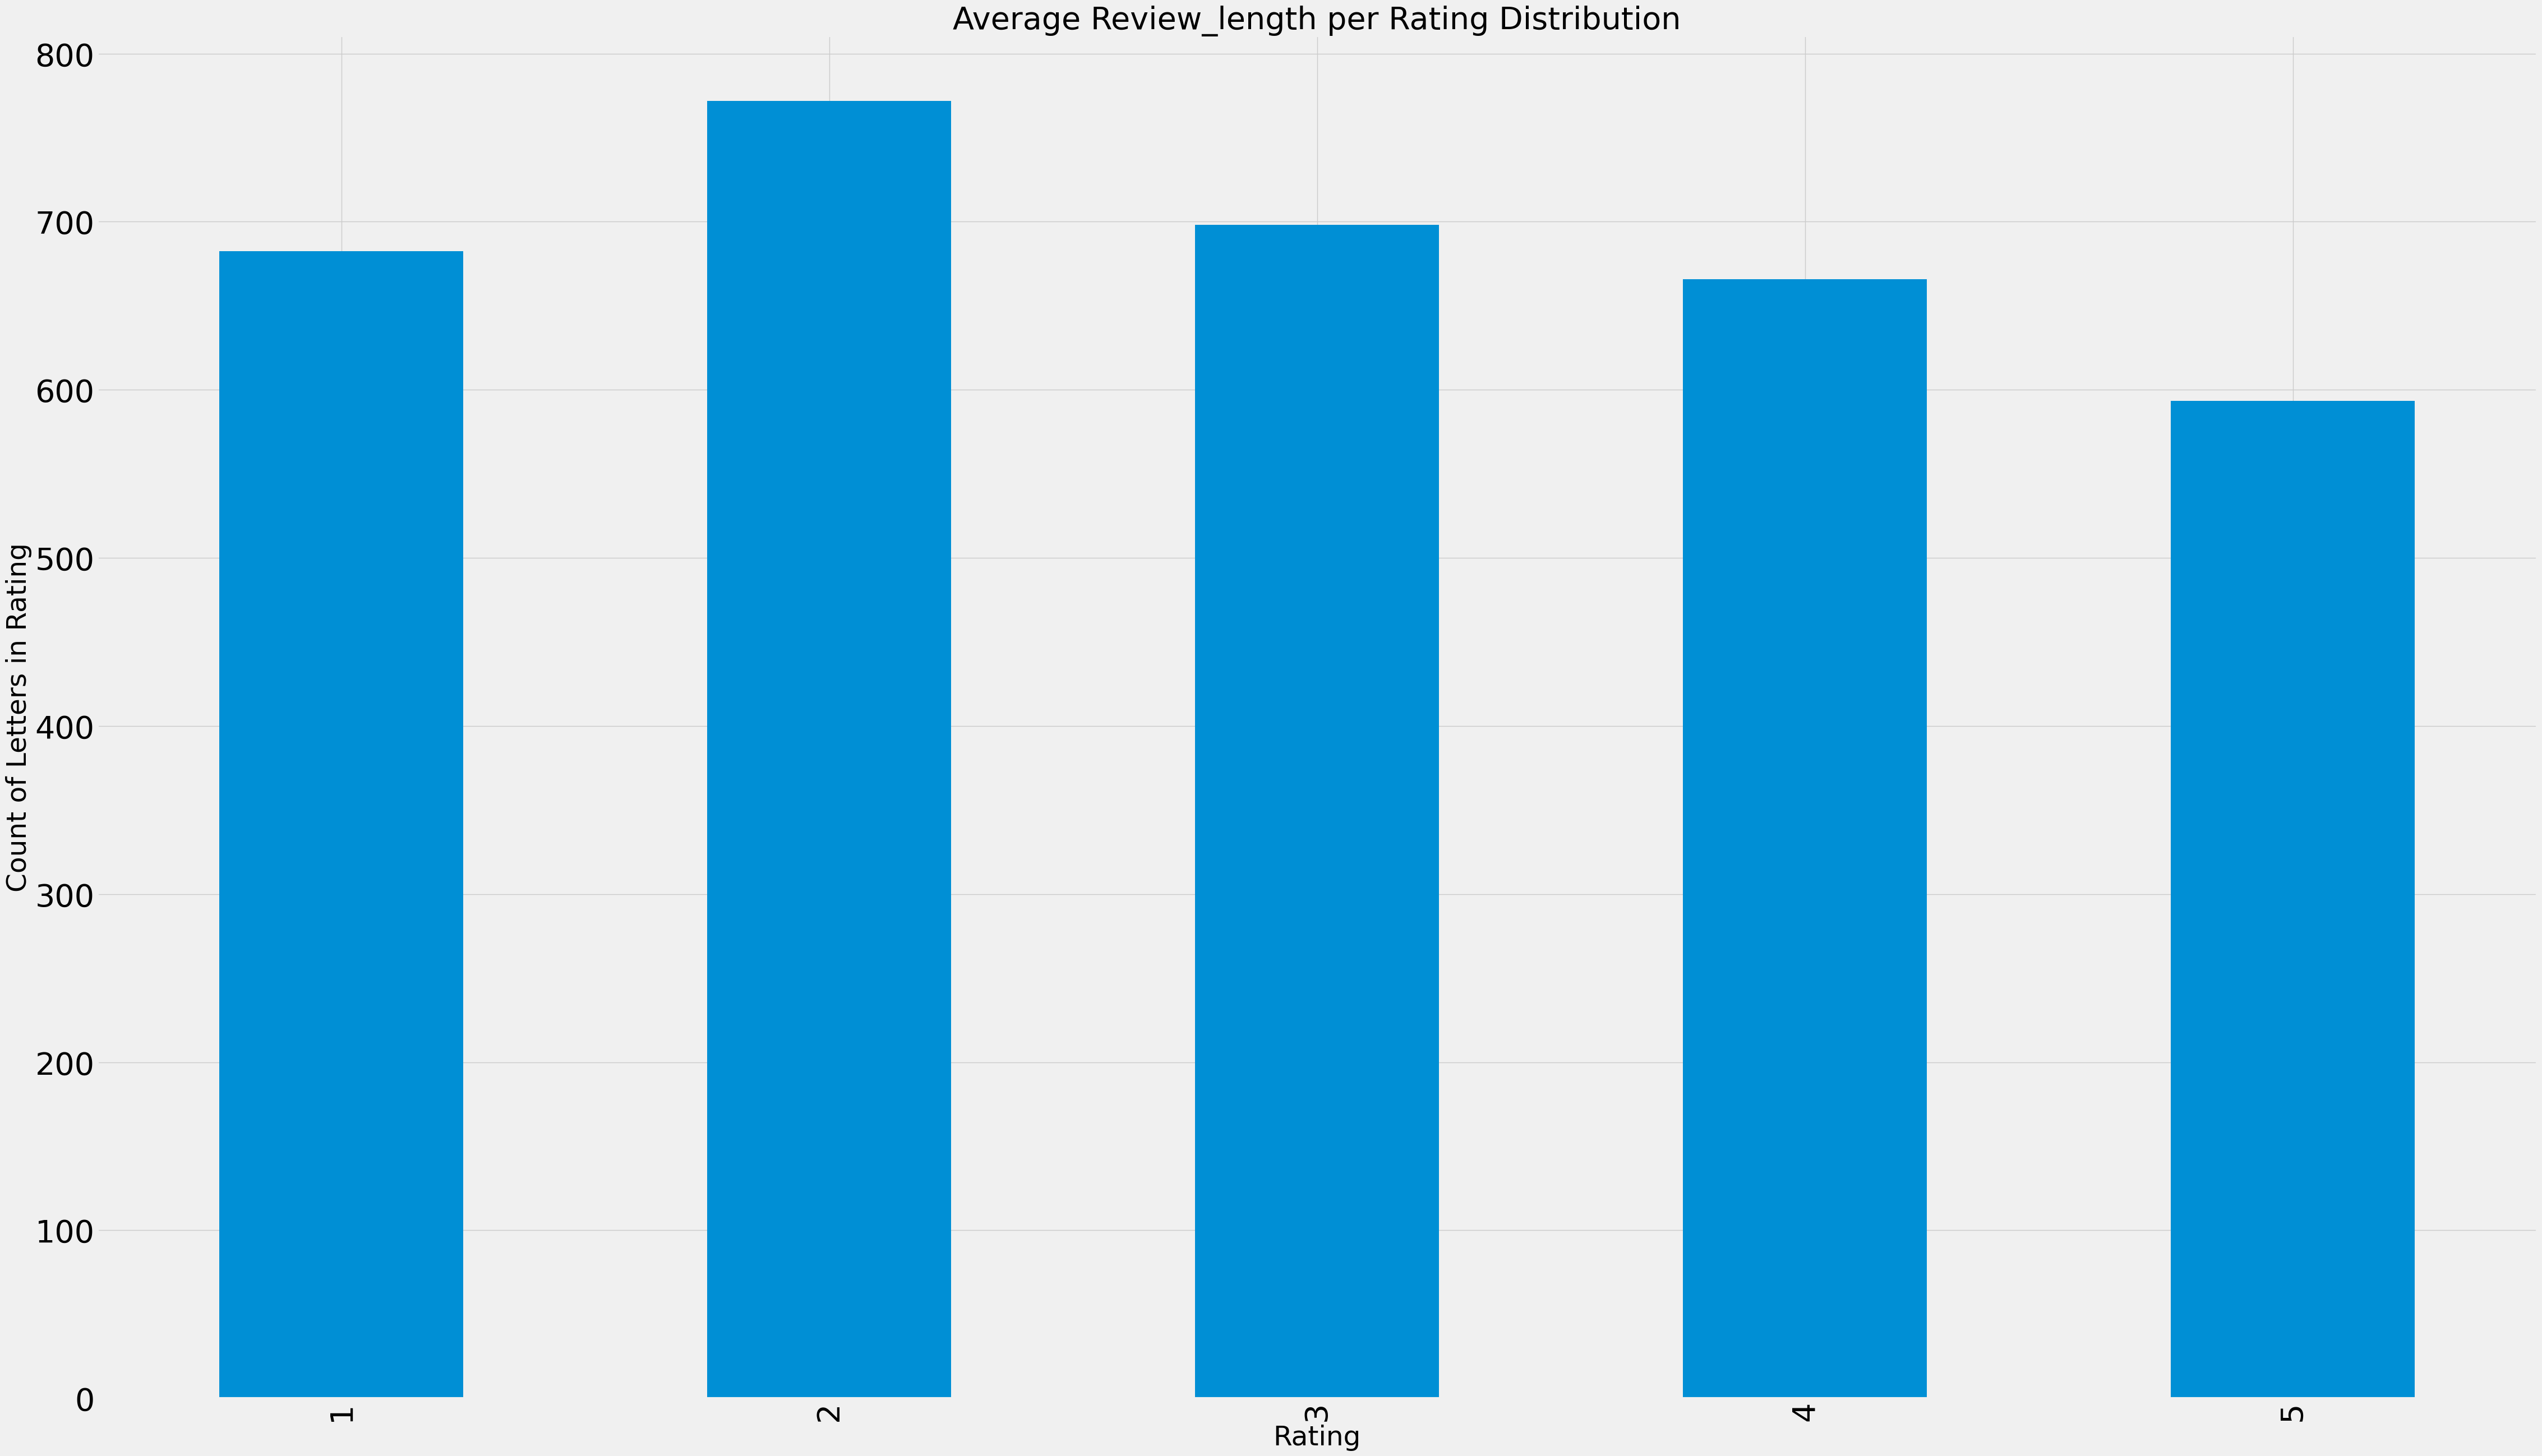

In [60]:
letter_avg = hotel_data.groupby('Rating')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Review_length per Rating Distribution', fontsize=40)
plt.show()

**Average review length per rating is more for rating 2**

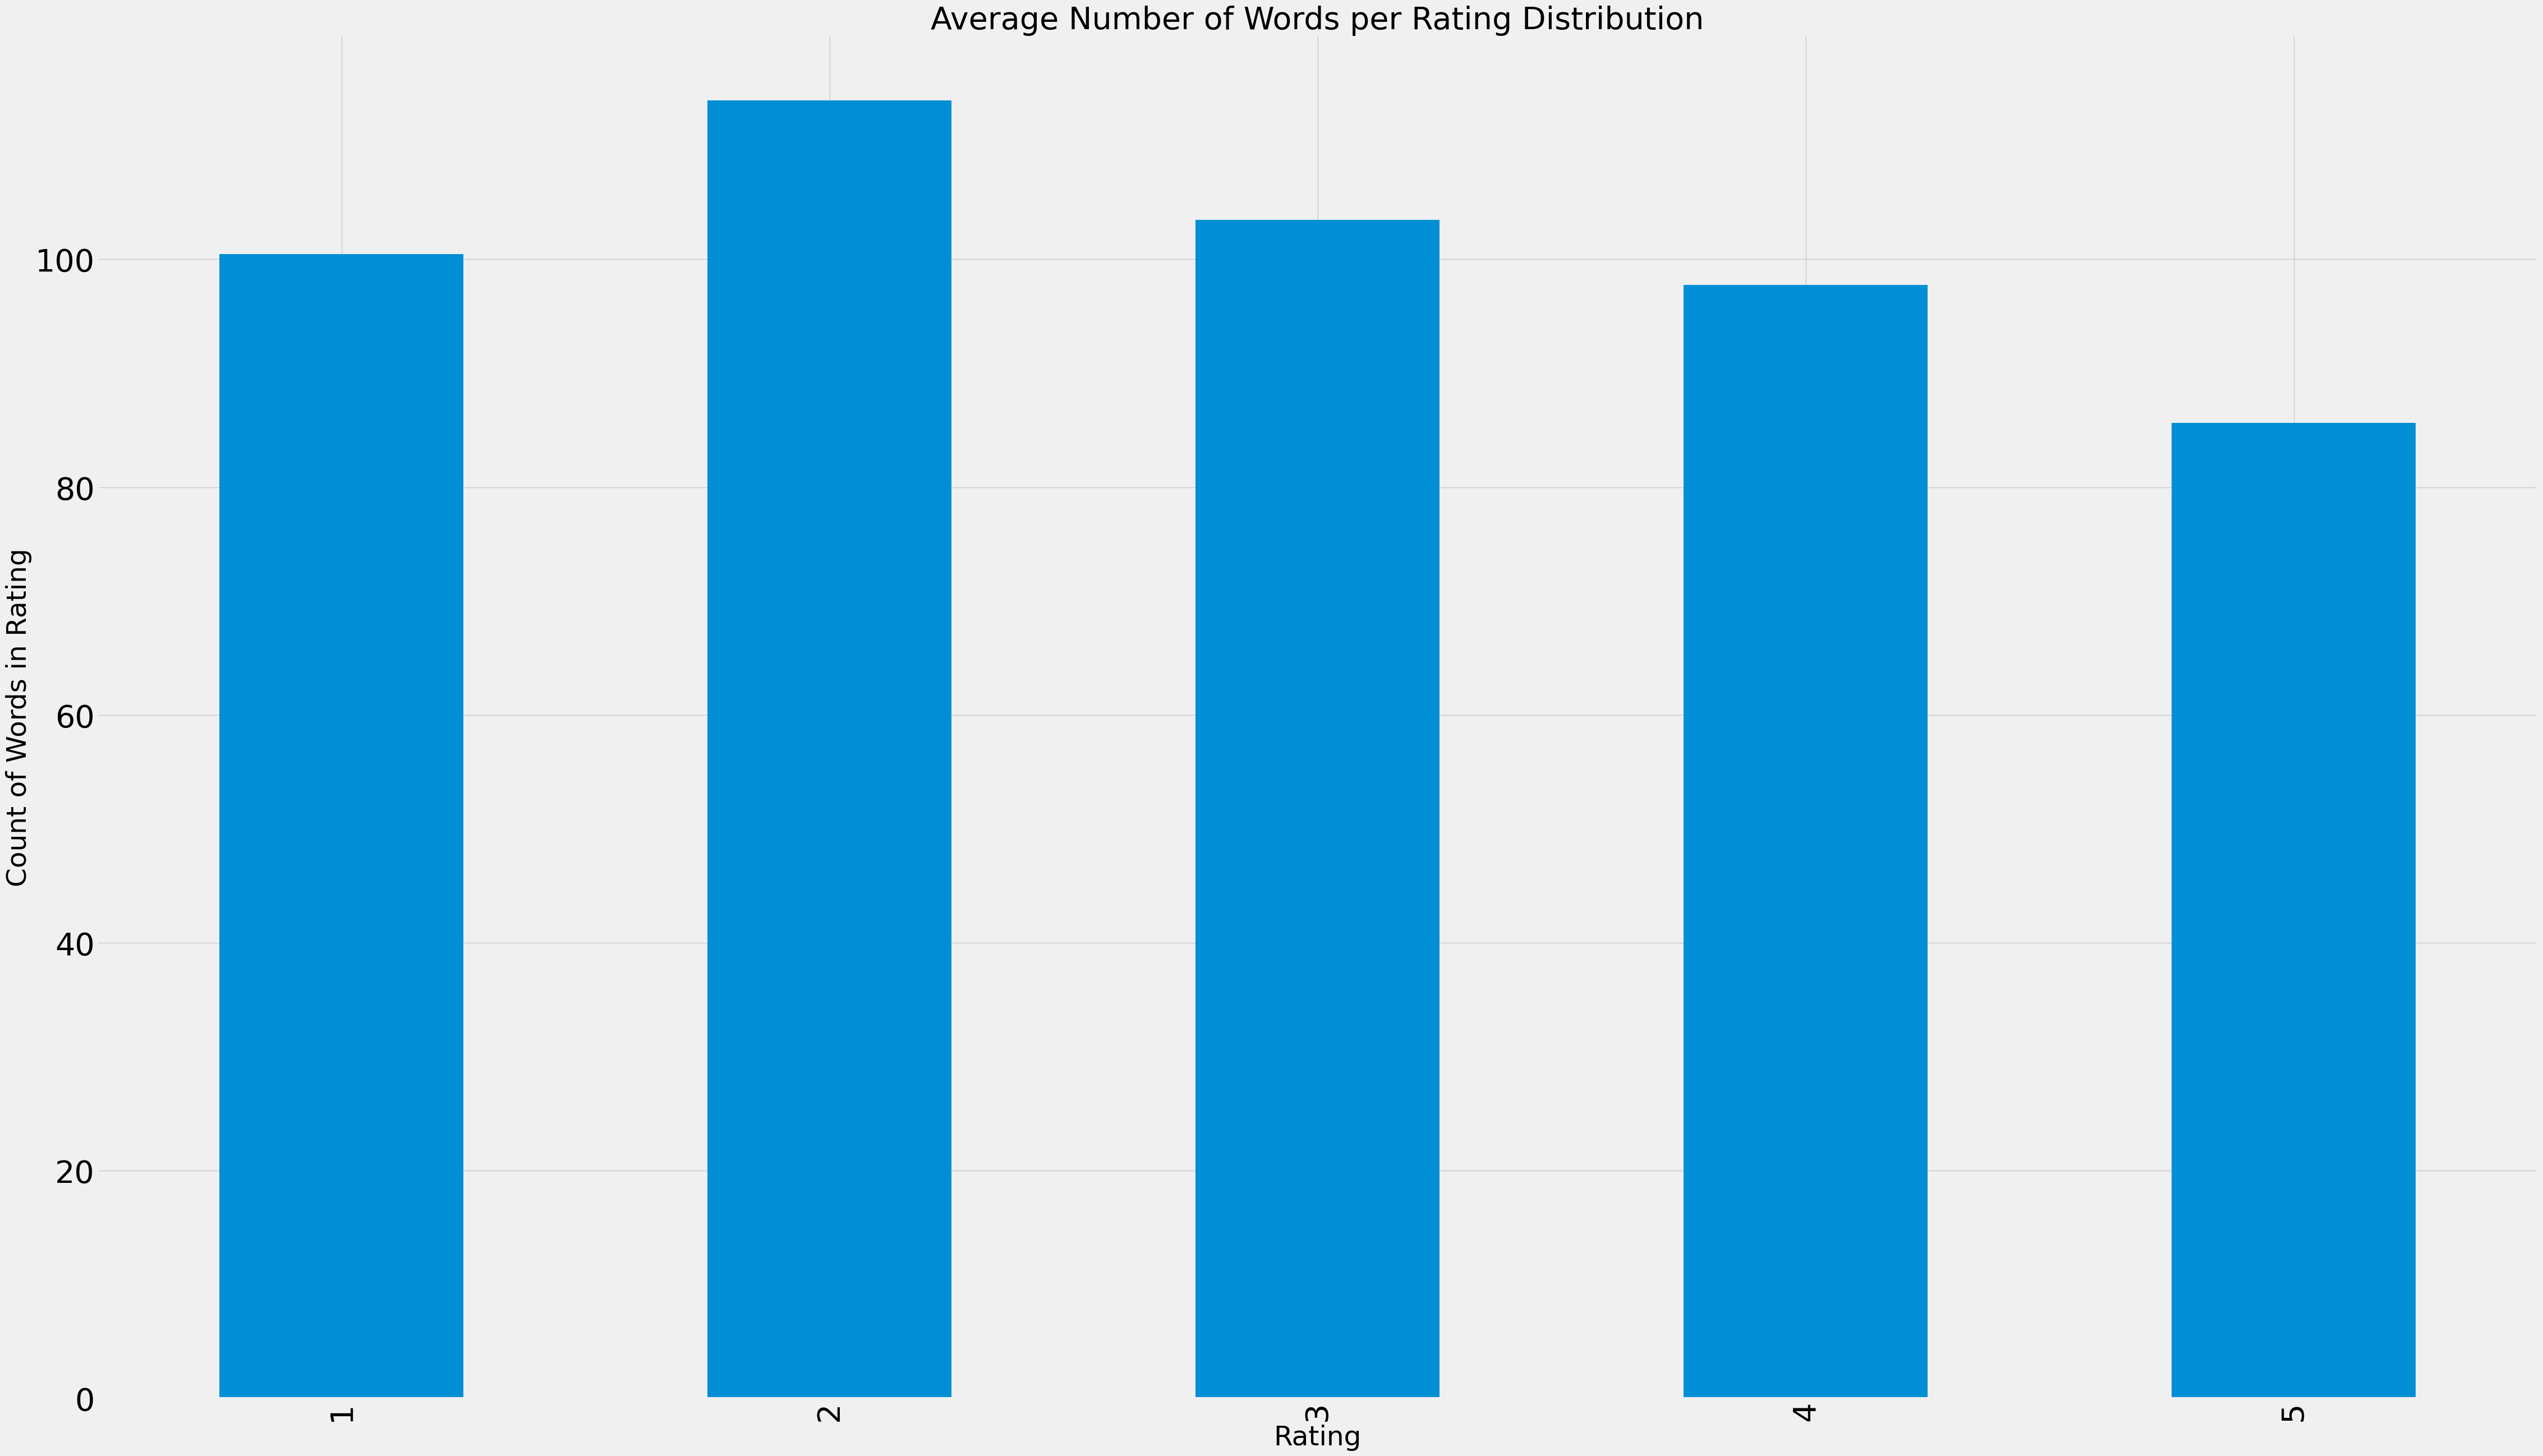

In [61]:
word_avg = hotel_data.groupby('Rating')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

**Average word count is also more for rating 2.But the difference is less for all the ratings**

<AxesSubplot:>

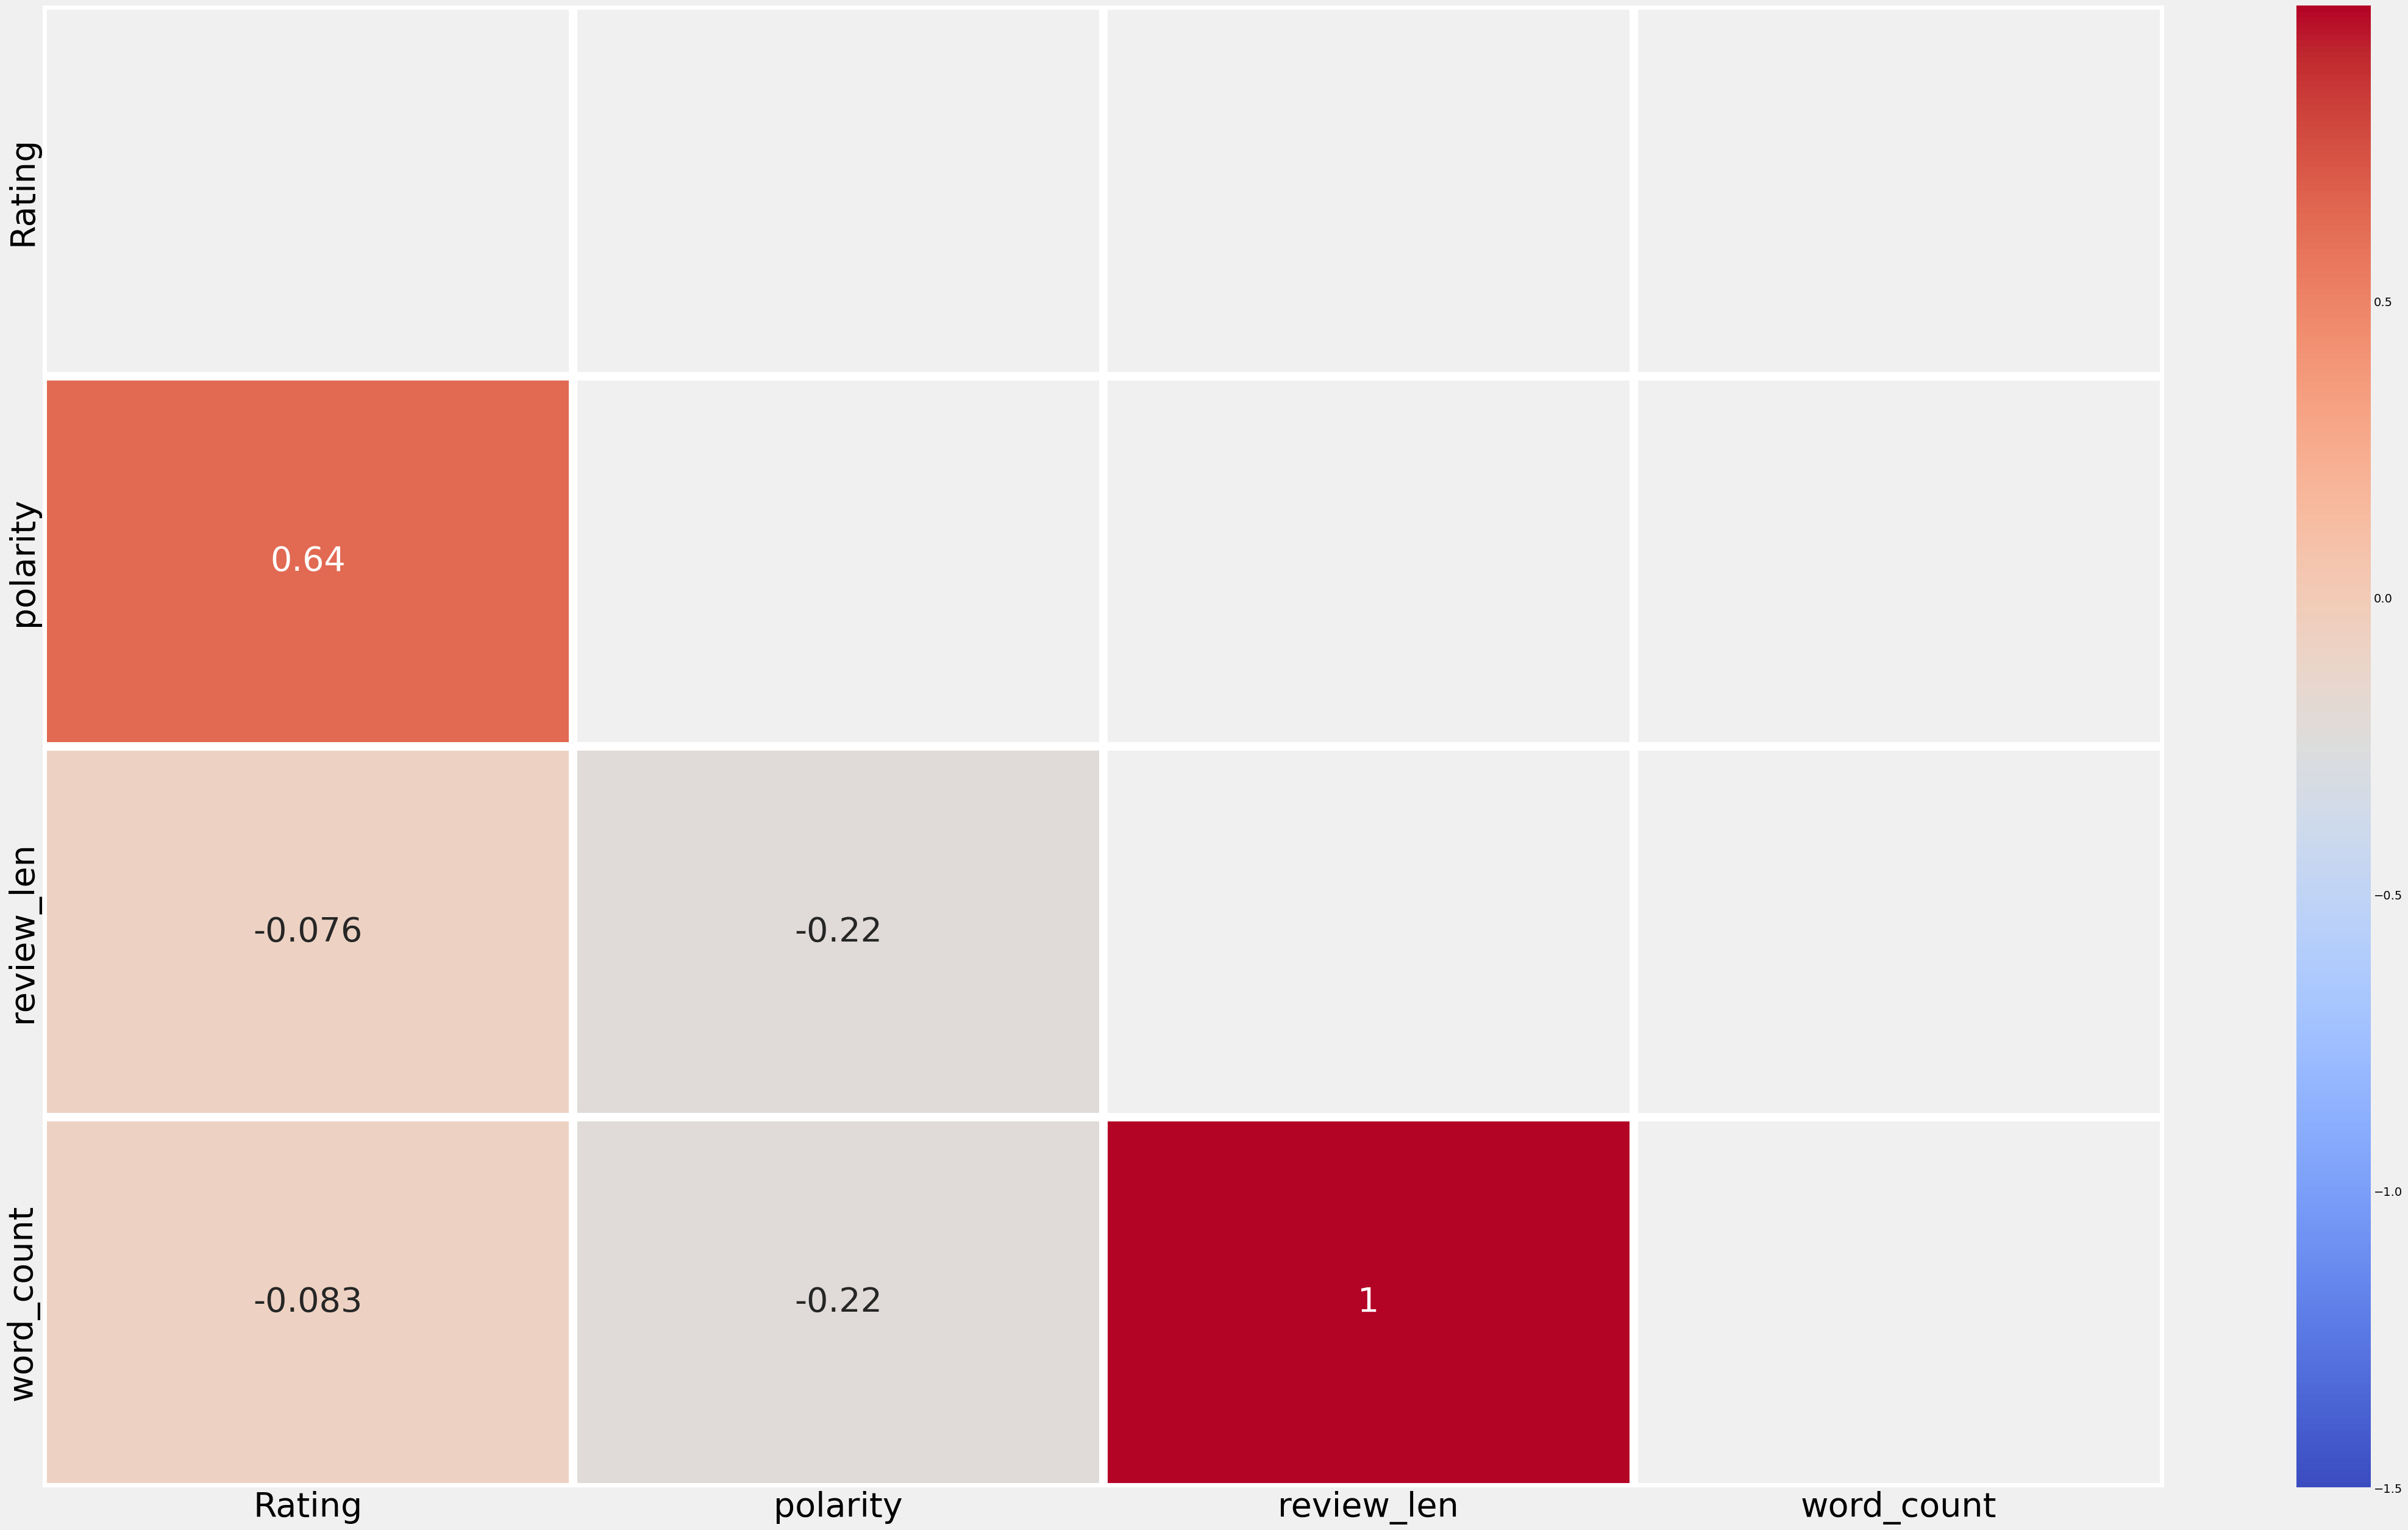

In [62]:
correlation = hotel_data[['Rating','polarity', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

## Model Building

In [63]:
hotel_data['Target'] = hotel_data['polarity'].apply(lambda x: 0 if x <0  else 1)

In [64]:
hotel_data.head()

Rating                                         lemmatized  \
0       4  [nice, expensive, parking, got, good, deal, st...   
1       2  [ok, nothing, special, charge, diamond, member...   
2       3  [nice, room, not, experience, monaco, seattle,...   
3       5  [unique, great, stay, wonderful, time, monaco,...   
4       5  [great, stay, great, stay, went, seahawk, game...   

                                           lemma_str  polarity  subjectivity  \
0  nice expensive parking got good deal stay anni...  0.208744      0.687000   
1  ok nothing special charge diamond member hilto...  0.227204      0.523295   
2  nice room not experience monaco seattle good n...  0.294420      0.605208   
3  unique great stay wonderful time monaco locati...  0.504825      0.691228   
4  great stay great stay went seahawk game awesom...  0.389286      0.627296   

  sentiment  word_count  review_len  Target  
0  Positive          77         523       1  
1  Positive         224        1534       1  
2  Positive         185        1252       1  
3  Positive          80         533       1  
4  Positive         176        1157       1

In [65]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(hotel_data['lemma_str'])
y = hotel_data['Target']

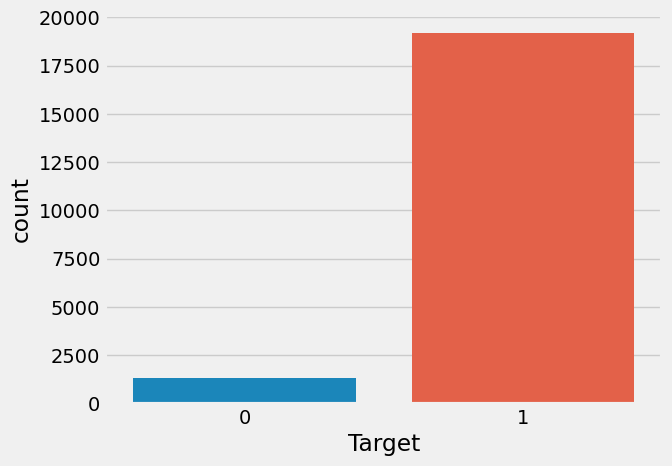

In [67]:
sns.countplot(x = 'Target',data=hotel_data)
plt.show()

**As the 0 is very less as compared to 1 in this dataset, We go with the oversampling to balance the values**

In [68]:
sm = SMOTE(sampling_strategy=0.7,random_state = 12)

In [69]:
X_sm,y_sm = sm.fit_resample(X,y)

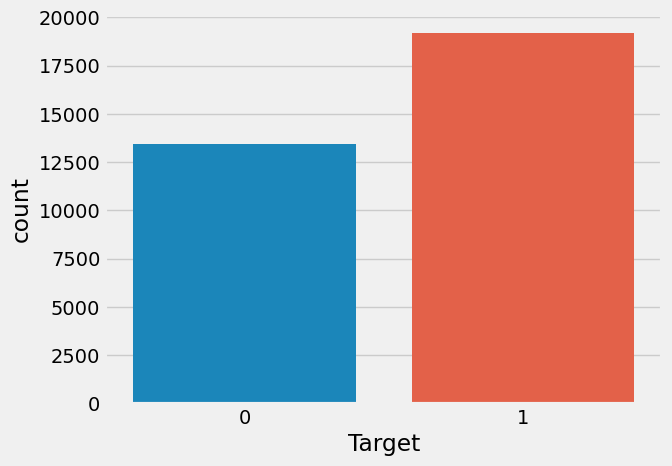

In [70]:
sns.countplot(y_sm)
plt.show()

In [71]:
data = hotel_data[['lemma_str','Target']]

In [72]:
data.head()

lemma_str  Target
0  nice expensive parking got good deal stay anni...       1
1  ok nothing special charge diamond member hilto...       1
2  nice room not experience monaco seattle good n...       1
3  unique great stay wonderful time monaco locati...       1
4  great stay great stay went seahawk game awesom...       1

In [73]:
#Segregating data into train & test
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state=0, test_size=0.3, shuffle=True, stratify=y_sm)

## 1.Logistic Regression model

In [74]:
classifier1 = LogisticRegression()
classifier1.fit(X_train,y_train)
classifier1.score(X_train,y_train)

0.9814555019728189

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      4232
           1       0.96      0.99      0.98      5545

    accuracy                           0.97      9777
   macro avg       0.97      0.97      0.97      9777
weighted avg       0.97      0.97      0.97      9777

Accuracy of LR Model: 97.1565920016365%


Text(0.5, 1.0, 'Confusion Matrix for LR Model')

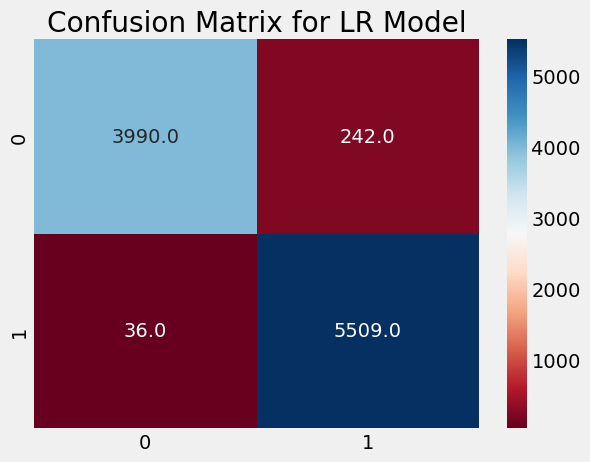

In [75]:
y_pred = classifier1.predict(X_test)
acc_LR = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LR Model: {}%".format(acc_LR*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LR Model")

In [76]:
y_pred_proba = classifier1.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for LR Classifier')

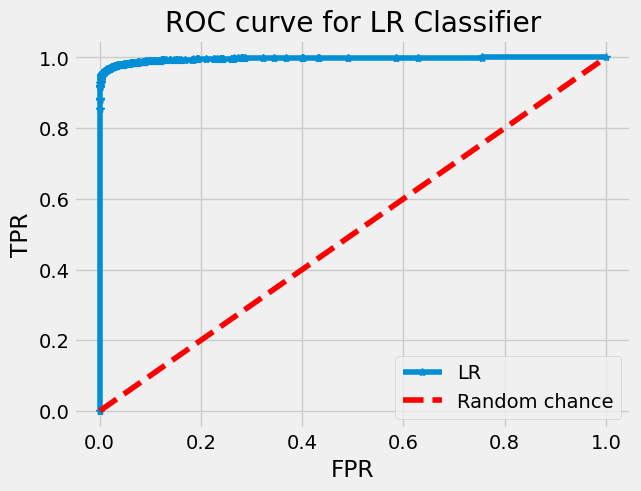

In [77]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LR', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LR Classifier')

### 2.Naive_bayes Model

In [78]:
classifier2 = MultinomialNB()
classifier2.fit(X_train,y_train)
classifier2.score(X_train,y_train)

0.9384918895221395

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      4395
           1       0.91      0.97      0.94      5382

    accuracy                           0.93      9777
   macro avg       0.93      0.92      0.93      9777
weighted avg       0.93      0.93      0.93      9777

Accuracy of NB Model: 92.87102383144114%


Text(0.5, 1.0, 'Confusion Matrix for NB Model')

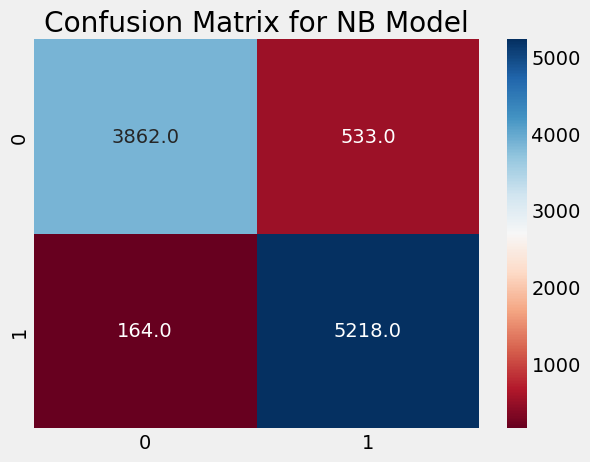

In [79]:
y_pred = classifier2.predict(X_test)
acc_NB = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of NB Model: {}%".format(acc_NB*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for NB Model")

In [80]:
y_pred_proba = classifier2.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for NB Classifier')

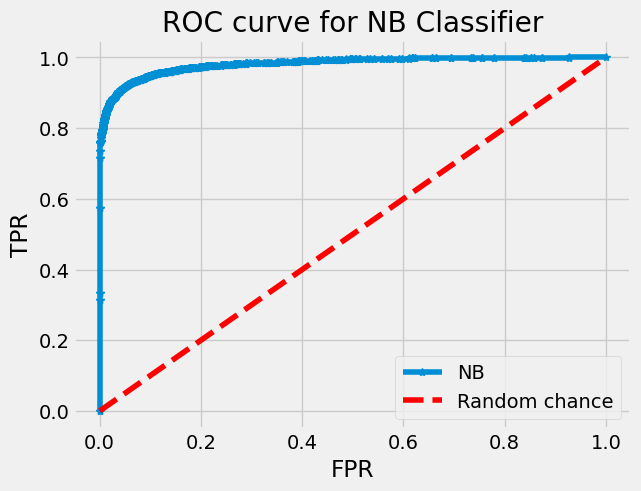

In [81]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['NB', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for NB Classifier')

### 3.Support Vector Machine

In [82]:
clf = SVC(kernel='linear',C= 15, gamma = 0.0001)
clf.fit(X_train , y_train)
clf.score(X_train,y_train)

1.0

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4152
           1       0.98      1.00      0.99      5625

    accuracy                           0.99      9777
   macro avg       0.99      0.98      0.99      9777
weighted avg       0.99      0.99      0.99      9777

Accuracy of SVM Model: 98.71126112304388%


Text(0.5, 1.0, 'Confusion Matrix for SVM Model')

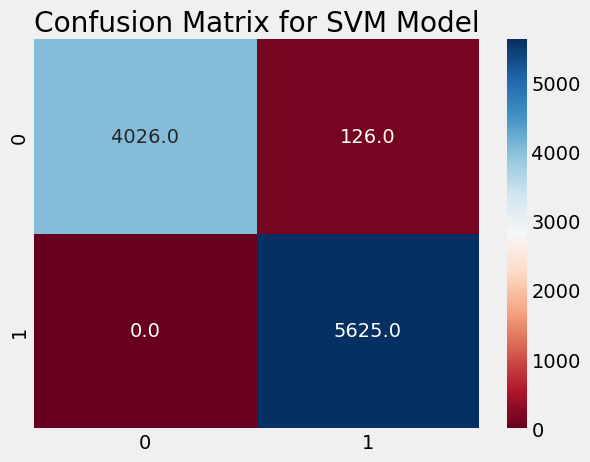

In [83]:
y_pred = clf.predict(X_test)
acc_svm = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of SVM Model: {}%".format(acc_svm*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for SVM Model")

### 4.KNN Model

In [73]:
#n_neighbors = np.array(range(1,81))
#param_grid = dict(n_neighbors=n_neighbors)
#param_grid

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])}

In [75]:
#KNN = KNeighborsClassifier()
#grid = GridSearchCV(estimator=KNN, param_grid=param_grid)
#grid.fit(X_train,y_train)

In [76]:
#print(grid.best_score_)
#print(grid.best_params_)

In [84]:
classifier4 = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
classifier4.fit(X_train, y_train)
classifier4.score(X_train,y_train)

1.0

              precision    recall  f1-score   support

           0       1.00      0.43      0.60      9303
           1       0.08      1.00      0.15       474

    accuracy                           0.46      9777
   macro avg       0.54      0.72      0.38      9777
weighted avg       0.96      0.46      0.58      9777

Accuracy of KNN Model: 46.02638846271863%


Text(0.5, 1.0, 'Confusion Matrix for KNN Model')

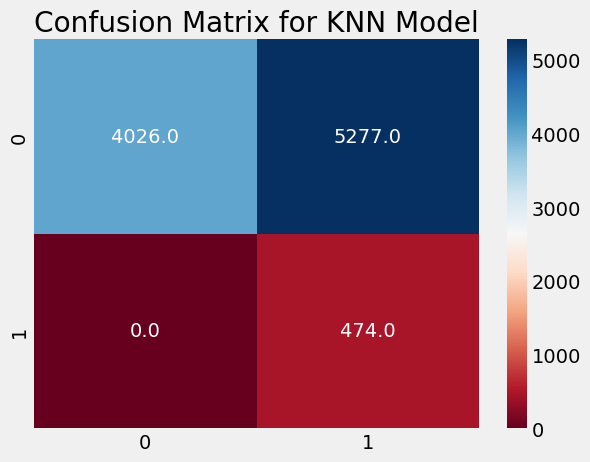

In [85]:
y_pred = classifier4.predict(X_test)
acc_KNN = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of KNN Model: {}%".format(acc_KNN*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for KNN Model")

In [86]:
y_pred_proba = classifier4.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for KNN Classifier')

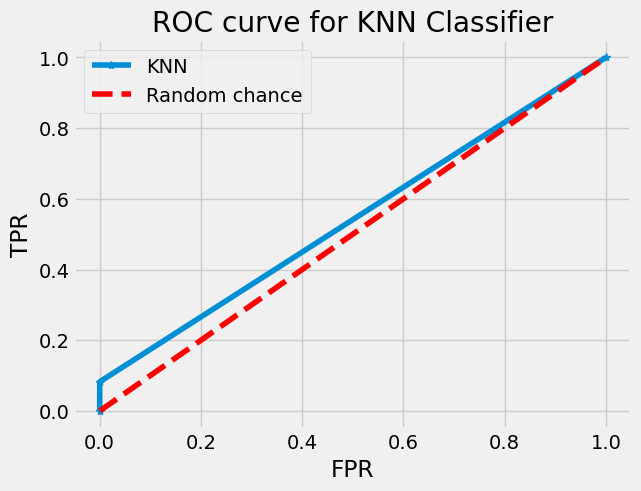

In [87]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['KNN', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for KNN Classifier')

### 5.Random forest Model

In [88]:
kfold = KFold(n_splits=10)

In [89]:
model = RandomForestClassifier(n_estimators=100,max_depth=3)
model.fit(X_train,y_train)
model.score(X_train,y_train)

0.7572555896536607

              precision    recall  f1-score   support

           0       0.42      0.96      0.58      1764
           1       0.99      0.71      0.83      8013

    accuracy                           0.75      9777
   macro avg       0.70      0.83      0.71      9777
weighted avg       0.89      0.75      0.78      9777

Accuracy of Random forest Model: 75.4116804745832%


Text(0.5, 1.0, 'Confusion Matrix for Random forest Model')

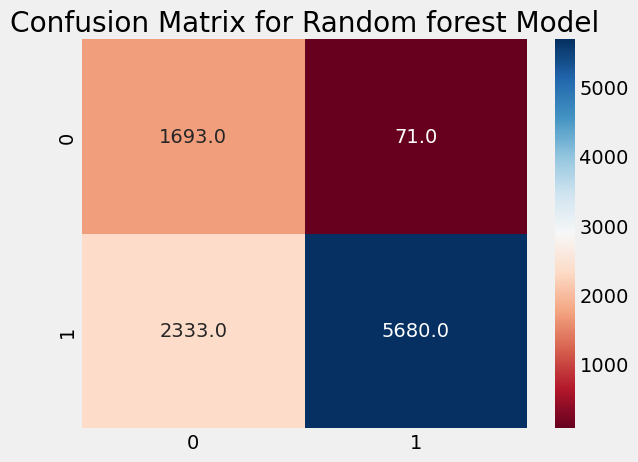

In [90]:
y_pred = model.predict(X_test)
acc_RF = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of Random forest Model: {}%".format(acc_RF*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for Random forest Model")

In [91]:
y_pred_proba = model.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for Random forest Classifier')

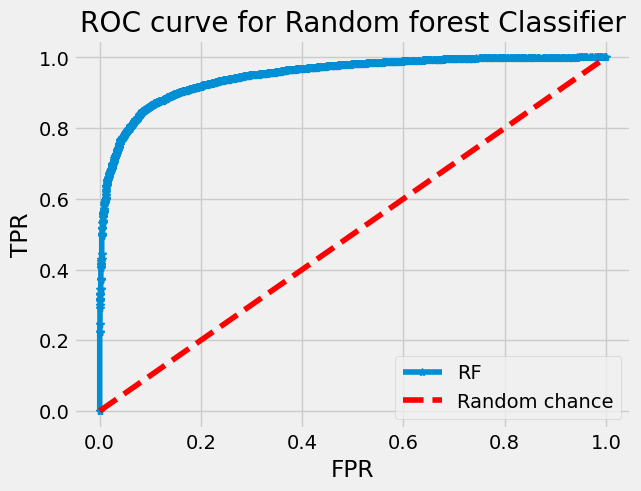

In [92]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['RF', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Random forest Classifier')

### 6.Light GBM Model

In [ ]:
#!pip install lightgbm

In [93]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
lgb.score(X_train, y_train)

0.9980710214818063

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4093
           1       0.98      0.99      0.98      5684

    accuracy                           0.98      9777
   macro avg       0.98      0.98      0.98      9777
weighted avg       0.98      0.98      0.98      9777

Accuracy of LGBM Model: 97.84187378541475%


Text(0.5, 1.0, 'Confusion Matrix for LGB Model')

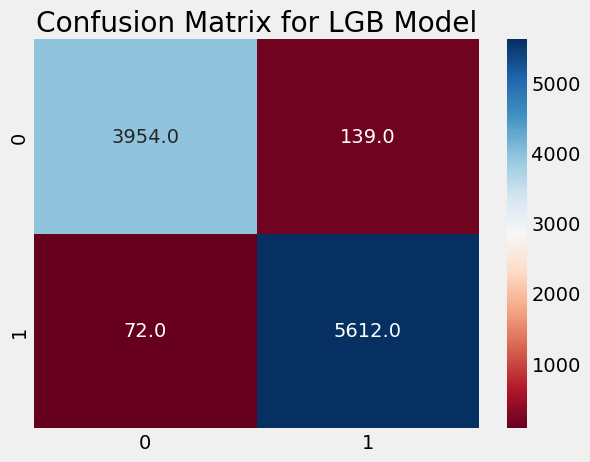

In [94]:
y_pred = lgb.predict(X_test)
acc_LGBM = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LGBM Model: {}%".format(acc_LGBM*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LGB Model")

Text(0.5, 1.0, 'ROC curve for LGB Classifier')

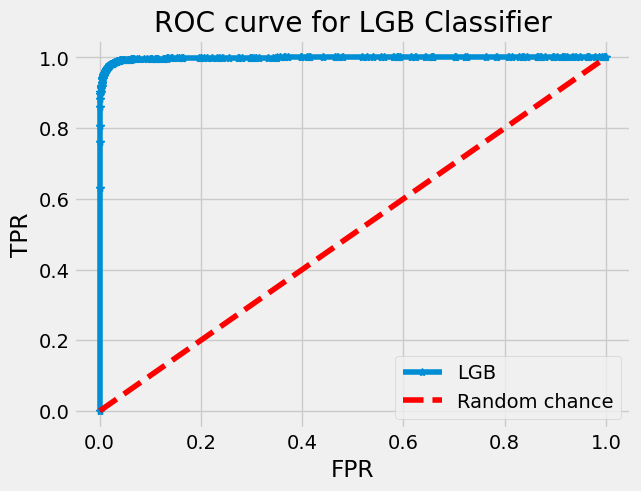

In [95]:
y_pred_proba = lgb.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LGB', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LGB Classifier')

## Selecting the Model

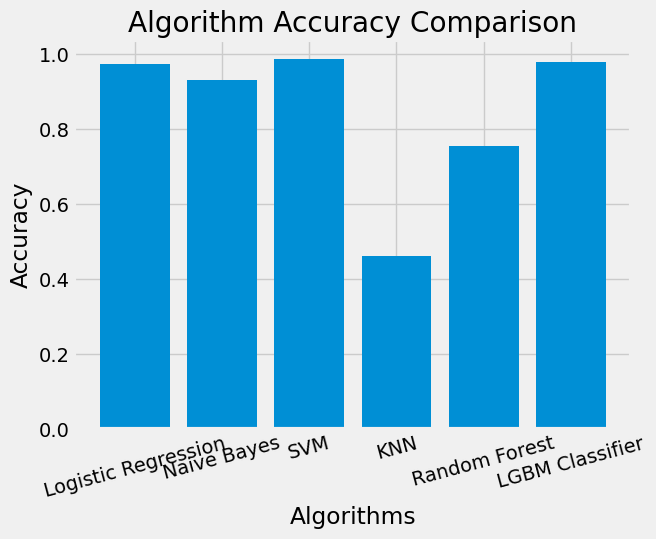

In [96]:
x = ["Logistic Regression","Naive Bayes","SVM","KNN","Random Forest","LGBM Classifier"]
y = [acc_LR,acc_NB,acc_svm,acc_KNN,acc_RF,acc_LGBM]
plt.bar(x=x, height=y)
plt.title("Algorithm Accuracy Comparison")
plt.xticks(rotation=15)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.show()

**As SVM has highest accuracy, this can be selected for the classification of the sentences**

## SVM model

In [97]:
def find_sentiment(Review):
    Review = expand_contractions(Review)
    Review = re.sub("[\d]+","",Review)
    Review = remove_punctuation(Review)
    Review = Review.lower()
    Review = word_tokenize(Review)
    Review = remove_stopwords(Review)
    Review = lemmatizer(Review)
    Review = ' '.join(Review)
    transformed_input = tfidf.transform([Review])
    score = TextBlob(Review)
    if clf.predict(transformed_input) == 1:
        if score.sentiment.polarity == 0:
            print("Neutral Statement")
            print("Polarity:",score.sentiment.polarity, "Subjectivity:",score.sentiment.subjectivity)
        else:
            print("Positive Statement")
            print("Polarity:",score.sentiment.polarity, "Subjectivity:",score.sentiment.subjectivity)
        
    else:
        print("Negative Statement")
        print("Polarity:",score.sentiment.polarity, "Subjectivity:",score.sentiment.subjectivity)       

In [126]:
Review = input("Please Enter your review:\n")
find_sentiment(Review)

Please Enter your review:
Worst experience
Negative Statement
Polarity: -1.0 Subjectivity: 1.0


In [127]:
Review = input("Please give us your valuable review here:\n")
find_sentiment(Review)

Please give us your valuable review here:
Beautiful location and infrastructure. Definitely recommend
Positive Statement
Polarity: 0.425 Subjectivity: 0.75


In [128]:
Review = input("Please give us your valuable review here:\n")
find_sentiment(Review)

Please give us your valuable review here:
woth money march bachelor party say dissappointed service received staff make short recommend
Neutral Statement
Polarity: 0.0 Subjectivity: 0.3


## Saving model into a pickle file

In [99]:
import pickle

In [100]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))

In [101]:
pickle.dump(classifier1, open('model.pkl', 'wb'))

In [103]:
pickled_model = pickle.load(open('model.pkl', 'rb'))